# Preamble

This is a re-analysis of the data published by Sundell et al. in 2017 (The Plant Cell, Vol. 29: 1585–1604). Their online atlas unfortunately does no longer exist, but the data is still very useful.

Keep in mind that results might differ slightly as the UMAP and Louvain algorithms are
stochastic in nature and no fixed seed was used.

## Versions used:

- Python 3.12.3
    - umap-learn 0.5.6
    - numpy 1.26.4
    - pandas 2.2.2
    - matplotlib 3.9.0
    - networkx 3.3
    - scipy 1.13.1
    - scikit-learn 1.5.0

- Linux binaries:
    - FastQC 0.11.9
    - multiQC 1.13
    - bbduk 38.97
    - STAR 2.7.10a
    - FeatureCounts 2.03

- R 4.3.0:
    - DESeq2 1.40.1
    - clusterProfiler 4.8.1
    - limma 3.54.1
    - UpSetR 1.4.0
    - tidyverse 2.0.0

# Set up environment

## Load modules

In [1]:
import os
import sys
import subprocess
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import numpy as np
import itertools
import string
from scipy.stats import rankdata
from sklearn.preprocessing import StandardScaler
from Bio import SeqIO
import math

## Define work environment

For re-use change wd (working directory) to match location of the data

In [2]:
RScriptPath = "/usr/local/bin/Rscript"
wd = "/Users/david/Documents/GitHub/Projects/Bioinformatics/ASPWOOD"
os.chdir(wd)
dataPath = "./RNASEQ/"
scriptPath = "./CODE/scripts/"

In [3]:
sys.path.append(f"../NGS-Analysis/classes/")

In [4]:
from SampleCommunitiesPCA import SampleCommunitiesPCA
from SampleUMAP import SampleUMAP
from CoRegulatoryNetworkAnalysis import CRN

# Count normalization, etc.

Runs an Rscript saved in the scriptPath.

Count normalization, log transformation (vst) of RNA-seq data using DESeq2.

Batch normalization using limma. We define Plant as batch while keeping the information about the distance.

In [10]:
subprocess.run([f"{RScriptPath}", f"{scriptPath}DESEQ2.R"])

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Lade nötiges Paket: S4Vectors
Lade nötiges Paket: stats4
Lade nötiges Paket: BiocGenerics

Attache Paket: ‘BiocGenerics’

Die folgenden Objekte sind maskiert von ‘package:lubridate’:

    intersect, setdiff, union

Die folgenden Objekte sind maskiert von ‘package:dplyr’:

    combine, intersect, setdiff, union

Die folgenden Objekte sind maskiert von ‘package:stats’:

    IQR, mad, sd, var, xtabs

Die folgenden Objekte sind maskiert von ‘package:base’:

    Filter, Find, 

[1] "creating variables"
[1] "change colnames in featureCounts"
[1] "K1.01"
[1] "K1.02"
[1] "K1.03"
[1] "K1.04"
[1] "K1.05"
[1] "K1.06"
[1] "K1.07"
[1] "K1.08"
[1] "K1.09"
[1] "K1.10"
[1] "K1.11"
[1] "K1.12"
[1] "K1.13"
[1] "K1.14"
[1] "K1.15"
[1] "K1.16"
[1] "K1.17"
[1] "K1.18"
[1] "K1.19"
[1] "K1.20"
[1] "K1.21"
[1] "K1.22"
[1] "K1.23"
[1] "K1.24"
[1] "K1.25"
[1] "K2.01"
[1] "K2.02"
[1] "K2.03"
[1] "K2.04"
[1] "K2.05"
[1] "K2.06"
[1] "K2.07"
[1] "K2.08"
[1] "K2.09"
[1] "K2.10"
[1] "K2.11"
[1] "K2.12"
[1] "K2.13"
[1] "K2.14"
[1] "K2.15"
[1] "K2.16"
[1] "K2.17"
[1] "K2.18"
[1] "K2.19"
[1] "K2.20"
[1] "K2.21"
[1] "K2.22"
[1] "K2.23"
[1] "K2.24"
[1] "K2.25"
[1] "K2.26"
[1] "K3.01"
[1] "K3.02"
[1] "K3.03"
[1] "K3.04"
[1] "K3.05"
[1] "K3.06"
[1] "K3.07"
[1] "K3.08"
[1] "K3.09"
[1] "K3.10"
[1] "K3.11"
[1] "K3.12"
[1] "K3.13"
[1] "K3.14"
[1] "K3.15"
[1] "K3.16"
[1] "K3.18"
[1] "K3.19"
[1] "K3.20"
[1] "K3.21"
[1] "K3.22"
[1] "K3.23"
[1] "K3.24"
[1] "K3.25"
[1] "K3.26"
[1] "K3.27"
[1] "K3.28"


CompletedProcess(args=['/usr/local/bin/Rscript', './CODE/scripts/DESEQ2.R'], returncode=0)

In [13]:
metaData = pd.read_csv(
    filepath_or_buffer=f"{dataPath}00_META_DATA/META_DATA.csv",
    index_col=0
    )
vst = pd.read_csv(
    filepath_or_buffer=f"{dataPath}08_DESEQ2/VST_LIMMA.csv",
    index_col=0
    )
vstRaw = pd.read_csv(
    filepath_or_buffer=f"{dataPath}08_DESEQ2/VST.csv",
    index_col=0
    )
norm=pd.read_csv(
    filepath_or_buffer=f"{dataPath}08_DESEQ2/NORMALIZED.csv",
    index_col=0
    )

# Execute Sample clustering

We use the previously loaded SampleCommunitiesPCA class. This class will run PCA and community detection on a KNN graph to determine clusters of samples for later statistical analysis.

The reason this is done is, because simply using the distance as design variable does not result in many DEGs, which is easily explainable due to the strong systemic differences between plants. This will become obvious in the first UMAP plot.

In [166]:
outputPath = f"{dataPath}09_SAMPLE_CLUSTERING/"
figurePath = f"{outputPath}FIGURES/"
os.makedirs(figurePath,exist_ok=True)


    
umap = SampleUMAP(vstRaw,norm,metaData)
umap.scale()
umap.depthFilter(50)
umap.umap(75,0.01,"cosine")
umap.extractData()

umapResRaw = umap.Export["UMAP"]
    
umapResRaw = metaData.join(umapResRaw)
umapResRaw.to_csv(f"{outputPath}UMAP_RAW.csv")

In [91]:
def umapPlot(plotData, colorValues, markerValues, figurePath):
    
    markers = ["o","s","^","P","p","v","+"]
    colors = plt.cm.plasma(np.linspace(0,1,len(plotData[colorValues].unique())))
    plotData["color"] = rankdata(plotData[colorValues],method="dense")-1
    plotData["marker"] = rankdata(plotData[markerValues],method="dense")-1
    f1 = lambda c: matplotlib.lines.Line2D([], [], linewidth=0, color = c, marker="o",
                                          markeredgecolor = "black", markeredgewidth=.1)
    handles1 = [f1(colors[i]) for i in plotData.color.unique()]
    labels1 = plotData[colorValues].unique()
    f2 = lambda m: matplotlib.lines.Line2D([], [], linewidth=0, color = "black", marker=m,
                                          markeredgecolor = "black", markeredgewidth=.1)
    handles2 = [f2(markers[i]) for i in plotData.marker.unique()]
    labels2 = plotData[markerValues].unique()
    plt.plasma()
    
    
    cm = 1/2.54
    fig, ax = plt.subplots()
    fig.set_size_inches(16*cm,14*cm)
    

        
    for markerIndex, marker in enumerate(plotData.marker):
    
        ax.scatter(x = plotData.UMAP1[markerIndex],y = plotData.UMAP2[markerIndex],
                        c = colors[plotData.color[markerIndex].astype(int)],s=64,
                        marker=markers[plotData.marker[markerIndex]],
                        linewidths=.25,edgecolor="black")
        ax.tick_params(labelsize=8,size=2)
        ax.spines[["top","right"]].set_visible(False)

    fig.supxlabel("UMAP1", fontsize = 10, weight = "bold")
    fig.supylabel("UMAP2", fontsize = 10, weight = "bold")
    legend1 = plt.legend(handles1,labels1,bbox_to_anchor = [1,.60,0,0],
                         title=colorValues, loc = "center left",markerscale = 0.75,
                         fontsize=6,title_fontsize=7,alignment="left",handletextpad=0.1)
    legend1.get_frame().set(linewidth=.75,edgecolor="black",facecolor="None")
    legend2 = plt.legend(handles2,labels2,bbox_to_anchor = [1,.12,0,0],
                         title=markerValues, loc = "center left",markerscale = 0.75,
                         fontsize=6,title_fontsize=7,alignment="left",handletextpad=0.1)
    legend2.get_frame().set(linewidth=.75,edgecolor="black",facecolor="None")
    fig.add_artist(legend1)
    fig.add_artist(legend2)
    legend1.set_in_layout(False)
    legend2.set_in_layout(False)
    plt.tight_layout()
    plt.subplots_adjust(top = .925, bottom = .1,right = 0.82, left = 0.15,hspace=0.35)
    
    fig.savefig(figurePath,dpi=600,transparent=True)
    plt.show()

/var/folders/2w/twsrzs4118b92tjrzbl1lpmc0000gn/T/ipykernel_3731/4081218185.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(x = plotData.UMAP1[markerIndex],y = plotData.UMAP2[markerIndex],
/var/folders/2w/twsrzs4118b92tjrzbl1lpmc0000gn/T/ipykernel_3731/4081218185.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c = colors[plotData.color[markerIndex].astype(int)],s=64,
/var/folders/2w/twsrzs4118b92tjrzbl1lpmc0000gn/T/ipykernel_3731/4081218185.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consiste

<Figure size 396.85x510.236 with 0 Axes>

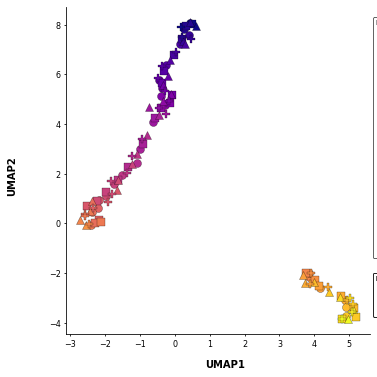

In [92]:
plotData = pd.read_csv(f"{outputPath}UMAP_RAW.csv",index_col=0)
umapPlot(plotData, "Distance", "Plant", f"{figurePath}UMAP_vstRaw.png")

## Run clustering

In [93]:
stem = SampleCommunitiesPCA(vst,norm,metaData,"Tissue","Stem")
stem.scale()
stem.depthFilter(50)
stem.pca(nFeatures=5000)
stem.louvain(10, 90, 15, "cosine", 1.5)
stem.umap(45,0.01,"cosine")
stem.extractData()

clusterMedians = stem.metaData.groupby("Cluster").median("Distance").sort_values("Distance")
for clusterIndex, cluster in enumerate(clusterMedians.index):
    stem.metaData.loc[stem.metaData.Cluster == cluster,"Cluster"] = string.ascii_uppercase[clusterIndex]

Using 39 PCs, explaining 0.9037843977999357 % of the total variance


/Users/david/Documents/GitHub/Projects/Bioinformatics/ASPWOOD/../NGS-Analysis/classes/SampleCommunitiesPCA.py:134: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'C0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.metaData.loc[self.Samples[self.Samples.isin(samples)],


In [94]:
metaDataClusters = stem.metaData.loc[metaData.index,:]
metaDataClusters.to_csv(f"{outputPath}META_DATA_CLUSTERS.csv")

def SaveData(name,path):
    file = metaDataClusters.join(stem.Export[name]).sort_values(["Cluster","Plant"])
    file.to_csv(path + name + ".csv")
    return file

pcaClustering = SaveData("PCA",outputPath)
umapClustering = SaveData("UMAP",outputPath)


/var/folders/2w/twsrzs4118b92tjrzbl1lpmc0000gn/T/ipykernel_3731/4081218185.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(x = plotData.UMAP1[markerIndex],y = plotData.UMAP2[markerIndex],
/var/folders/2w/twsrzs4118b92tjrzbl1lpmc0000gn/T/ipykernel_3731/4081218185.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  c = colors[plotData.color[markerIndex].astype(int)],s=64,
/var/folders/2w/twsrzs4118b92tjrzbl1lpmc0000gn/T/ipykernel_3731/4081218185.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consiste

<Figure size 396.85x510.236 with 0 Axes>

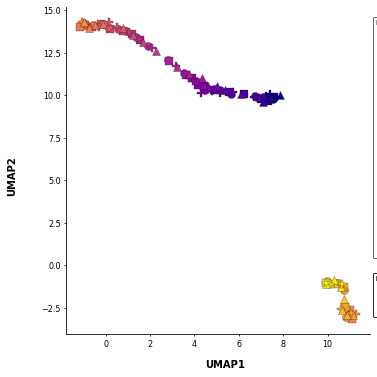

<Figure size 396.85x510.236 with 0 Axes>

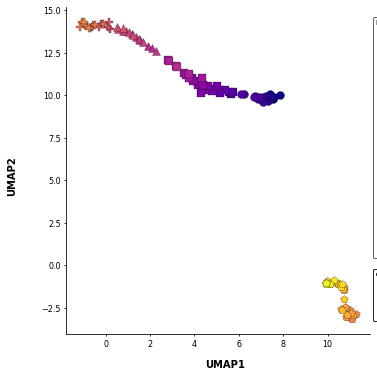

In [95]:
plotData = pd.read_csv(f"{outputPath}UMAP.csv",index_col=0).sort_values(["Distance","Cluster"])

umapPlot(plotData, "Distance", "Plant", f"{figurePath}UMAP_PLANT.png")
umapPlot(plotData, "Distance", "Cluster", f"{figurePath}UMAP_CLUSTER.png")

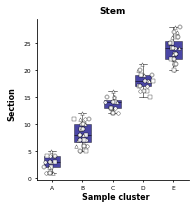

In [103]:
metaDataClusters = pd.read_csv(f"{outputPath}META_DATA_CLUSTERS.csv", index_col=0)
plotData = metaDataClusters.copy()

markers = np.array(["o","s","^","P","p","v","+"])
colors = plt.cm.plasma(np.linspace(0,1,len(plotData.Tissue.unique())))
plotData["color"] = rankdata(plotData.Tissue,method="dense")-1
plotData["marker"] = rankdata(plotData.Plant,method="dense")-1
f1 = lambda c: matplotlib.lines.Line2D([], [], linewidth=0, color = c, marker="o",
                                      markeredgecolor = "black", markeredgewidth=.1)
handles1 = [f1(colors[i]) for i in plotData.color.unique()]
labels1 = plotData.Tissue.unique()
f2 = lambda m: matplotlib.lines.Line2D([], [], linewidth=0, color = "black", marker=m,
                                      markeredgecolor = "black", markeredgewidth=.1)
handles2 = [f2(markers[i]) for i in plotData.marker.unique()]
labels2 = plotData.Plant.unique()
plotData.Cluster=plotData.Cluster.astype(str)
plotData["color"] = rankdata(plotData.Tissue,method="dense")-1
plotDataGrouped = plotData.groupby("Tissue")

cm = 1/2.54
fig, ax = plt.subplots(1,1, sharey = True)
fig.set_size_inches(8*cm,7*cm)

for index, tissue in enumerate(metaData.Tissue.unique()): 
    plotDataTissue = plotDataGrouped.get_group(tissue)
    clusters = plotDataTissue.Cluster.unique()
    f = lambda cluster: plotDataTissue.loc[plotDataTissue.Cluster == cluster,"Distance"].to_numpy()
    dataset = [f(cluster) for cluster in plotDataTissue.Cluster.unique()]
    ax.set_axis_on()
    box = ax.boxplot(dataset,showfliers=False,widths=0.55,patch_artist=True,
                                    positions=range(len(plotDataTissue.Cluster.unique())), zorder=0)
    for i,j in zip(box["boxes"],box["medians"]):
        i.set(facecolor=colors[plotDataTissue.color][0],edgecolor="black",linewidth=.5,alpha=.75)
        j.set(c="black",linewidth=0.5)
    for i,j in zip(box["whiskers"],box["caps"]):
        i.set(c="black",linewidth=.5)
        j.set(c="black",linewidth=.5)
    ax.tick_params(labelsize=6,size=2)
    ax.set_title(tissue, size = 9, weight="bold")
    ax.set_xticklabels(plotDataTissue.Cluster.unique())
    ax.spines[["top","right"]].set_visible(False)

    plotDataTissueGrouped = plotDataTissue.groupby("Plant")
    
    for markerIndex, plant in enumerate(plotDataTissue.Plant.unique()):
        
        plotDataTissuePlant = plotDataTissueGrouped.get_group(plant)
        
        f = lambda cluster: plotDataTissuePlant.loc[plotDataTissuePlant.Cluster == cluster,"Distance"].to_numpy()
        dataset = [f(cluster) for cluster in plotDataTissuePlant.Cluster.unique()]
        
        for cluster, value in enumerate(dataset):
            group = np.random.normal(cluster, 0.125, size=len(value))
            scatter = ax.scatter(group,value,s=12,linewidths=.35,marker=markers[plotDataTissuePlant.marker.values[0]],
                                        c="white",edgecolor="black",zorder=1,alpha=0.9)
            
fig.supxlabel("Sample cluster", fontsize = 8, weight="bold")
fig.supylabel("Section", fontsize = 8, weight="bold")

legend1 = plt.legend(handles1,labels1,bbox_to_anchor = [1,2.2,0,0],
                     title="Tissue", loc = "center left",markerscale = 0.75,
                     fontsize=6,title_fontsize=7,alignment="left",handletextpad=0.1)
legend1.get_frame().set(linewidth=.75,edgecolor="black",facecolor="None")

legend2 = plt.legend(handles2,labels2,bbox_to_anchor = [1,1.75,0,0],
                     title="Plant", loc = "center left",markerscale = 0.75,
                     fontsize=6,title_fontsize=7,alignment="left",handletextpad=0.1)
legend2.get_frame().set(linewidth=.75,edgecolor="black",facecolor="None")

fig.add_artist(legend1)
fig.add_artist(legend2)
legend1.set_in_layout(False)
legend2.set_in_layout(False)


plt.tight_layout()
plt.subplots_adjust(top = .925, bottom = .115,right = 0.82, left = 0.15,hspace=0.35)
fig.savefig(f"{figurePath}CLUSTER_DISTANCE.png",dpi=600,transparent=True)
plt.show()

In [167]:
metaDataClusters = pd.read_csv(f"{outputPath}META_DATA_CLUSTERS.csv", index_col=0)
metaDataClusters["clusterName"] = np.nan
metaDataClusters.loc[metaDataClusters.Cluster == "A","clusterName"] = "Phloem"
metaDataClusters.loc[metaDataClusters.Cluster == "B","clusterName"] = "Cambium"
metaDataClusters.loc[metaDataClusters.Cluster == "C","clusterName"] = "XylemTransition"
metaDataClusters.loc[metaDataClusters.Cluster == "D","clusterName"] = "XylemI"
metaDataClusters.loc[metaDataClusters.Cluster == "E","clusterName"] = "XylemII"

metaDataClusters["clusterNameShort"] = np.nan
metaDataClusters.loc[metaDataClusters.Cluster == "A","clusterNameShort"] = "P"
metaDataClusters.loc[metaDataClusters.Cluster == "B","clusterNameShort"] = "C"
metaDataClusters.loc[metaDataClusters.Cluster == "C","clusterNameShort"] = "XT"
metaDataClusters.loc[metaDataClusters.Cluster == "D","clusterNameShort"] = "X1"
metaDataClusters.loc[metaDataClusters.Cluster == "E","clusterNameShort"] = "X2"

metaDataClusters.to_csv(f"{outputPath}META_DATA_CLUSTERS.csv")

/var/folders/2w/twsrzs4118b92tjrzbl1lpmc0000gn/T/ipykernel_3731/486702233.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Phloem' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metaDataClusters.loc[metaDataClusters.Cluster == "A","clusterName"] = "Phloem"
/var/folders/2w/twsrzs4118b92tjrzbl1lpmc0000gn/T/ipykernel_3731/486702233.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'P' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metaDataClusters.loc[metaDataClusters.Cluster == "A","clusterNameShort"] = "P"


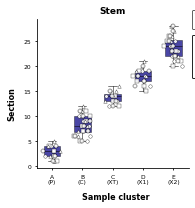

In [168]:
metaDataClusters = pd.read_csv(f"{outputPath}META_DATA_CLUSTERS.csv", index_col=0)
plotData = metaDataClusters.copy()
plotData.Cluster = metaDataClusters.Cluster + "\n(" + metaDataClusters.clusterNameShort +")"

markers = np.array(["o","s","^","P","p","v","+"])
colors = plt.cm.plasma(np.linspace(0,1,len(plotData.Tissue.unique())))
plotData["color"] = rankdata(plotData.Tissue,method="dense")-1
plotData["marker"] = rankdata(plotData.Plant,method="dense")-1
f1 = lambda c: matplotlib.lines.Line2D([], [], linewidth=0, color = c, marker="o",
                                      markeredgecolor = "black", markeredgewidth=.1)
handles1 = [f1(colors[i]) for i in plotData.color.unique()]
labels1 = plotData.Tissue.unique()
f2 = lambda m: matplotlib.lines.Line2D([], [], linewidth=0, color = "black", marker=m,
                                      markeredgecolor = "black", markeredgewidth=.1)
handles2 = [f2(markers[i]) for i in plotData.marker.unique()]
labels2 = plotData.Plant.unique()
plotData.Cluster=plotData.Cluster.astype(str)
plotData["color"] = rankdata(plotData.Tissue,method="dense")-1
plotDataGrouped = plotData.groupby("Tissue")

cm = 1/2.54
fig, ax = plt.subplots(1,1, sharey = True)
fig.set_size_inches(8*cm,7*cm)

for index, tissue in enumerate(metaData.Tissue.unique()): 
    plotDataTissue = plotDataGrouped.get_group(tissue)
    clusters = plotDataTissue.Cluster.unique()
    f = lambda cluster: plotDataTissue.loc[plotDataTissue.Cluster == cluster,"Distance"].to_numpy()
    dataset = [f(cluster) for cluster in plotDataTissue.Cluster.unique()]
    ax.set_axis_on()
    box = ax.boxplot(dataset,showfliers=False,widths=0.55,patch_artist=True,
                                    positions=range(len(plotDataTissue.Cluster.unique())), zorder=0)
    for i,j in zip(box["boxes"],box["medians"]):
        i.set(facecolor=colors[plotDataTissue.color][0],edgecolor="black",linewidth=.5,alpha=.75)
        j.set(c="black",linewidth=0.5)
    for i,j in zip(box["whiskers"],box["caps"]):
        i.set(c="black",linewidth=.5)
        j.set(c="black",linewidth=.5)
    ax.tick_params(labelsize=6,size=2)
    ax.set_title(tissue, size = 9, weight="bold")
    ax.set_xticklabels(plotDataTissue.Cluster.unique())
    ax.spines[["top","right"]].set_visible(False)

    plotDataTissueGrouped = plotDataTissue.groupby("Plant")
    
    for markerIndex, plant in enumerate(plotDataTissue.Plant.unique()):
        
        plotDataTissuePlant = plotDataTissueGrouped.get_group(plant)
        
        f = lambda cluster: plotDataTissuePlant.loc[plotDataTissuePlant.Cluster == cluster,"Distance"].to_numpy()
        dataset = [f(cluster) for cluster in plotDataTissuePlant.Cluster.unique()]
        
        for cluster, value in enumerate(dataset):
            group = np.random.normal(cluster, 0.125, size=len(value))
            scatter = ax.scatter(group,value,s=12,linewidths=.35,marker=markers[plotDataTissuePlant.marker.values[0]],
                                        c="white",edgecolor="black",zorder=1,alpha=0.9)
            
fig.supxlabel("Sample cluster", fontsize = 8, weight="bold")
fig.supylabel("Section", fontsize = 8, weight="bold")

legend1 = plt.legend(handles1,labels1,bbox_to_anchor = [1,1,0,0],
                     title="Tissue", loc = "center left",markerscale = 0.75,
                     fontsize=6,title_fontsize=7,alignment="left",handletextpad=0.1)
legend1.get_frame().set(linewidth=.75,edgecolor="black",facecolor="None")

legend2 = plt.legend(handles2,labels2,bbox_to_anchor = [1,.75,0,0],
                     title="Plant", loc = "center left",markerscale = 0.75,
                     fontsize=6,title_fontsize=7,alignment="left",handletextpad=0.1)
legend2.get_frame().set(linewidth=.75,edgecolor="black",facecolor="None")

fig.add_artist(legend1)
fig.add_artist(legend2)
legend1.set_in_layout(False)
legend2.set_in_layout(False)


plt.tight_layout()
plt.subplots_adjust(top = .925, bottom = .175,right = 0.82, left = 0.15,hspace=0.35)
fig.savefig(f"{figurePath}CLUSTER_DISTANCE.png",dpi=600,transparent=True)
plt.show()

# Gene expression clustering

Now we can execute statistical analysis for each tissue to find DEGs, which we will then cluster to find interesting expression profiles, if present.

In [114]:
subprocess.run([f"{RScriptPath}", f"{scriptPath}LRT.R"])

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Lade nötiges Paket: S4Vectors
Lade nötiges Paket: stats4
Lade nötiges Paket: BiocGenerics

Attache Paket: ‘BiocGenerics’

Die folgenden Objekte sind maskiert von ‘package:lubridate’:

    intersect, setdiff, union

Die folgenden Objekte sind maskiert von ‘package:dplyr’:

    combine, intersect, setdiff, union

Die folgenden Objekte sind maskiert von ‘package:stats’:

    IQR, mad, sd, var, xtabs

Die folgenden Objekte sind maskiert von ‘package:base’:

    Filter, Find, 

[1] "creating variables"
[1] "change colnames in featureCounts"
[1] "K1.01"
[1] "K1.02"
[1] "K1.03"
[1] "K1.04"
[1] "K1.05"
[1] "K1.06"
[1] "K1.07"
[1] "K1.08"
[1] "K1.09"
[1] "K1.10"
[1] "K1.11"
[1] "K1.12"
[1] "K1.13"
[1] "K1.14"
[1] "K1.15"
[1] "K1.16"
[1] "K1.17"
[1] "K1.18"
[1] "K1.19"
[1] "K1.20"
[1] "K1.21"
[1] "K1.22"
[1] "K1.23"
[1] "K1.24"
[1] "K1.25"
[1] "K2.01"
[1] "K2.02"
[1] "K2.03"
[1] "K2.04"
[1] "K2.05"
[1] "K2.06"
[1] "K2.07"
[1] "K2.08"
[1] "K2.09"
[1] "K2.10"
[1] "K2.11"
[1] "K2.12"
[1] "K2.13"
[1] "K2.14"
[1] "K2.15"
[1] "K2.16"
[1] "K2.17"
[1] "K2.18"
[1] "K2.19"
[1] "K2.20"
[1] "K2.21"
[1] "K2.22"
[1] "K2.23"
[1] "K2.24"
[1] "K2.25"
[1] "K2.26"
[1] "K3.01"
[1] "K3.02"
[1] "K3.03"
[1] "K3.04"
[1] "K3.05"
[1] "K3.06"
[1] "K3.07"
[1] "K3.08"
[1] "K3.09"
[1] "K3.10"
[1] "K3.11"
[1] "K3.12"
[1] "K3.13"
[1] "K3.14"
[1] "K3.15"
[1] "K3.16"
[1] "K3.18"
[1] "K3.19"
[1] "K3.20"
[1] "K3.21"
[1] "K3.22"
[1] "K3.23"
[1] "K3.24"
[1] "K3.25"
[1] "K3.26"
[1] "K3.27"
[1] "K3.28"


Warnmeldung:
In DESeqDataSet(se, design = design, ignoreRank) :
  some variables in design formula are characters, converting to factors
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 32 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


CompletedProcess(args=['/usr/local/bin/Rscript', './CODE/scripts/LRT.R'], returncode=0)

## Clustering

The LRT does tell us, which genes are DEGs, but does give information about the underlying expression profile. To find those we use a clustering technique called community detection.

The reasong we use community detection over traditional clustering methods like k-means or DBSCAN is that these usually do not perform very well on RNA-seq data. Community detection does not work on the raw data, but on a graph/network that we first produce. Graphs are a very natural way of representing complex systems like transcriptome networks. We are specifically interested in co-regulation, hence we draw edges between genes with a positive pearson correlation coefficient in the data. This produces an adjacency matrix, which can be converted into a networkx graph on which we will execute the Louvain community detection algorithm. The drawback is that isolated genes (outliers) will affect the clustering negatively. To avoid that disconnected genes will be removed before executing community detection.

All of this is done with the CRN class from CoRegulatoryNetworkAnalysis.py.

### Setup

In [5]:
# create and define path
outputPath = f"{dataPath}10_CRN/"
figurePath = f"{outputPath}FIGURES/"
os.makedirs(figurePath,exist_ok=True)

# load data
lrt = pd.read_csv(f"{dataPath}08_DESEQ2/LRT.csv",index_col=0)
metaDataClusters = pd.read_csv(f"{dataPath}09_SAMPLE_CLUSTERING/META_DATA_CLUSTERS.csv",index_col=0)

In [120]:
ASPWOOD_CRN = CRN(vst,norm,metaDataClusters,lrt)
ASPWOOD_CRN.scale()
ASPWOOD_CRN.pValFilter(0.001)
ASPWOOD_CRN.corrNetwork(filterType="pValue",corrThrsh=0.8, runPCA = True, minPCs=10, minPctVar=90)
ASPWOOD_CRN.networkGeneration(remove = True)
ASPWOOD_CRN.louvain(minEdges=25, minClusterSize=50, minClusterDegreeRatio = 0, resolution=1.0)
ASPWOOD_CRN.umap(25,0,"correlation")
ASPWOOD_CRN.extractData()

Executing PCA
Using 16 PCs, explaining 90.83768214502001 % of the total variance
Generating graph from Network. This might take a while...
Removing 2853 genes: low connectivity
Executing Louvain algorithm. This might take a while...
0
Removing 0 genes: low connectivity within community
1
Removing 0 genes: low connectivity within community
2
Removing 0 genes: low connectivity within community
3
Removing 0 genes: low connectivity within community
4
Removing 0 genes: low connectivity within community
5
Removing 0 genes: low connectivity within community
6
Removing 0 genes: low connectivity within community


In [123]:
clusters = ASPWOOD_CRN.Clusters
clusters.to_csv(f"{outputPath}CLUSTERS.csv")
umapGene = ASPWOOD_CRN.Export["UMAP"]
umapGene = clusters.reset_index().merge(umapGene.reset_index()).set_index("index")
umapGene.to_csv(f"{outputPath}umapGene.csv")
scaled = ASPWOOD_CRN.Export["Scaled"]
scaled.to_csv(f"{outputPath}SCALED.csv")

## Plot results

First a UMAP plot of the DEGs with cluster information is plotted and saved, then violin plot depicting the expression profile of each found cluster.

The code loads in all necessary data, so we only ned to run the clustering once.

NameError: name 'tissue' is not defined

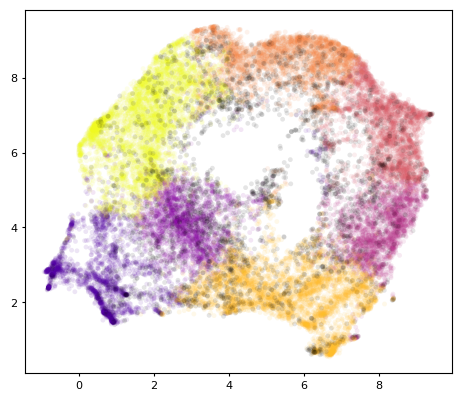

In [6]:
# redefine to avoid necessary re-running
outputPath = f"{dataPath}10_CRN/"
figurePath = f"{outputPath}FIGURES/"
umapGene = pd.read_csv(f"{outputPath}umapGene.csv",index_col=0)
umapGene.Cluster=umapGene.Cluster.astype(str)

plotData = umapGene.copy()
colors = plt.cm.plasma(np.linspace(0,1,len(plotData.Cluster.unique())))
colors[0] = np.array([0, 0, 0, 1])
plotData["color"] = rankdata(plotData.Cluster,method="dense")-1
f = lambda c: matplotlib.lines.Line2D([], [], linewidth=0, color = c, marker="o",
                                      markeredgecolor = "black", markeredgewidth=.1)
handles = [f(colors[i]) for i in plotData.color.unique()]
labels = plotData.Cluster.unique()

cm = 1/2.54
fig, ax = plt.subplots()
fig.set_size_inches(14*cm,12*cm)
ax.scatter(x = plotData.UMAP1,y = plotData.UMAP2,
                c = colors[plotData.color.astype(int)],marker="o",s=12,
                linewidths=0,edgecolor="black",alpha=.1)
ax.tick_params(labelsize=8,size=2)
ax.set_title(tissue, size = 9,weight="bold")
ax.spines[["top","right"]].set_visible(False)
    
fig.supxlabel("UMAP1", fontsize = 10,weight="bold")
fig.supylabel("UMAP2", fontsize = 10,weight="bold")

legend = plt.legend(handles,labels,bbox_to_anchor = [1,.9,0,0],
                     title="Cluster", loc = "center left",markerscale = 0.75,
                     fontsize=6,title_fontsize=7,alignment="left",handletextpad=0.1)
legend.get_frame().set(linewidth = 0.75, edgecolor="black",facecolor="None")

fig.add_artist(legend)
legend.set_in_layout(False)

plt.tight_layout()
plt.subplots_adjust(top = .9, bottom = .10,right = 0.835, left = 0.135,hspace=.35)
fig.savefig(f"{figurePath}UMAP_CLUSTERS.png",dpi=600,transparent=True)
plt.show()

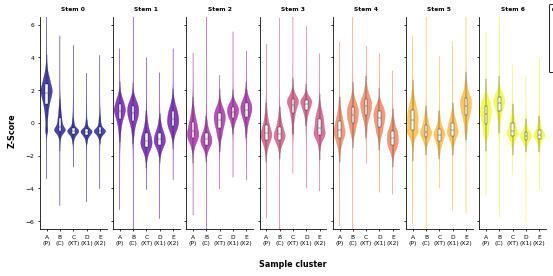

In [170]:
scaled = pd.read_csv(f"{outputPath}SCALED.csv",index_col=0)


metaDataClusters = pd.read_csv(f"{dataPath}09_SAMPLE_CLUSTERING/META_DATA_CLUSTERS.csv",index_col=0)
sampleClusters = metaDataClusters.copy().reset_index()
sampleClusters["sampleCluster"] = sampleClusters.Cluster + "\n(" + sampleClusters.clusterNameShort +")"
sampleClusters = sampleClusters.drop(columns = ["Cluster","clusterName","clusterNameShort"])

umapGene = pd.read_csv(f"{outputPath}umapGene.csv",index_col=0)
umapGene.Cluster=umapGene.Cluster.astype(str)

plotData = umapGene.copy().loc[umapGene.Cluster != "-1",:]
colors = plt.cm.plasma(np.linspace(0,1,len(plotData.Cluster.unique())))
plotData["color"] = rankdata(plotData.Cluster,method="dense")-1
f = lambda c: matplotlib.lines.Line2D([], [], linewidth=0, color = c, marker="o",
                                      markeredgecolor = "black", markeredgewidth=.1)
handles = [f(colors[i]) for i in plotData.color.unique()]
labels = plotData.Cluster.unique()


cm = 1/2.54
fig, ax = plt.subplots(1,len(plotData.Cluster.unique()), sharey = True)
    
fig.set_size_inches(21*cm,10*cm)
samples = sampleClusters.loc[sampleClusters.Tissue == tissue,"Sample"]
plotData = plotData.join(scaled.loc[:,samples]
    ).melt(id_vars = plotData.columns,var_name="Sample").merge(sampleClusters,how="left")
clusters = plotData.Cluster.unique()
plotData = plotData.groupby("Cluster")
for index, geneCluster in enumerate(clusters):
    plotDataCluster = plotData.get_group(geneCluster)
    f = lambda cluster: plotDataCluster.loc[plotDataCluster.sampleCluster == cluster,"value"].to_numpy()
    dataset = [f(i) for i in plotDataCluster.sampleCluster.unique()]
    ax[index].set_axis_on()
    violin = ax[index].violinplot(dataset,showextrema=False,
                                                widths=0.85,positions=range(len(plotDataCluster.sampleCluster.unique())))
    box = ax[index].boxplot(dataset,showfliers=False,widths=0.2,patch_artist=True,
                                    positions=range(len(plotDataCluster.sampleCluster.unique())))
    ax[index].tick_params(labelsize=6,size=2)
    ax[index].set_title( tissue + " " +geneCluster, size = 6,weight="bold")
    ax[index].set_xticklabels(plotDataCluster.sampleCluster.unique())
    ax[index]
    for i in violin["bodies"]:
        i.set(color=colors[plotDataCluster.color],alpha=.75,linewidth=.35)
    for i,j in zip(box["boxes"],box["medians"]):
        i.set(facecolor="white",edgecolor="black",linewidth=.35)
        j.set(c="black",linewidth=0.35)
    for i,j in zip(box["whiskers"],box["caps"]):
        i.set(c="black",linewidth=.35)
        j.set(c="black",linewidth=0)
    plt.ylim([-6.5,6.5])
    ax[index].spines[["top","right"]].set_visible(False)
fig.supxlabel("Sample cluster", fontsize = 8,weight="bold")
fig.supylabel("Z-Score", fontsize = 8,weight="bold")
legend = plt.legend(handles,labels,bbox_to_anchor = [1,.9,0,0],
                     title="Cluster", loc = "center left",markerscale = 0.75,
                     fontsize=6,title_fontsize=7,alignment="left",handletextpad=0.1)
legend.get_frame().set(linewidth = 0.75, edgecolor="black",facecolor="None")
fig.add_artist(legend)
legend.set_in_layout(False)
plt.tight_layout()
plt.subplots_adjust(top = .9, bottom = .15,right = 0.925, left = 0.075,hspace=.35,wspace=.1)
fig.savefig(f"{figurePath}CLUSTER_EXPRESSION.png",dpi=600,transparent=True)
plt.show()


# Interpretation

## Marker gene expression

First, we plot expression of manually curated marker genes. These should behave as expected.

In [163]:
scaled = pd.read_csv(f"{outputPath}SCALED.csv",index_col=0)

sampleClusters = metaDataClusters.copy().reset_index()
sampleClusters["sampleCluster"] = sampleClusters.Cluster + "\n(" + sampleClusters.clusterNameShort +")"
sampleClusters = sampleClusters.drop(columns = ["Cluster","clusterName","clusterNameShort"])

umapGene = pd.read_csv(f"{outputPath}umapGene.csv",index_col=0)
umapGene.Cluster=umapGene.Cluster.astype(str)

AtMarkers = pd.read_csv(f"{dataPath}00_META_DATA/AT_MARKER.csv")
blast = pd.read_csv(f"{dataPath}00_META_DATA/Ptrichocarpa_RECIPROCAL_HIT_ARAPORT11_BLASTP.csv")

PtMarkers = AtMarkers.merge(blast).merge(umapGene.reset_index(names="Geneid"))


PtMarkers["Symbol"] = PtMarkers.Symbol + " | " +  PtMarkers.Cluster

scaler = StandardScaler()
scaled = pd.DataFrame(data=scaler.fit_transform(vst.T).T,
                      columns=vst.columns,index=vst.index)

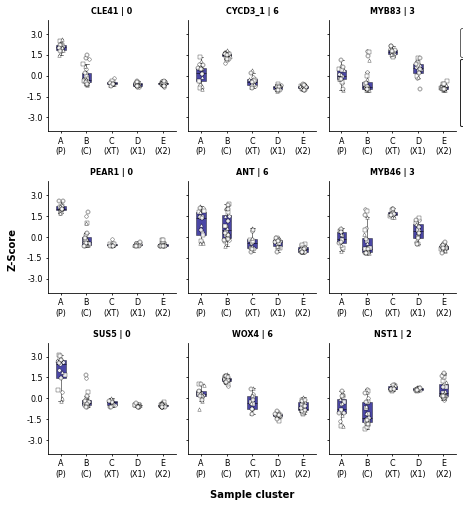

In [171]:

plotData = scaled.copy().reset_index(names="Geneid").merge(PtMarkers)
plotData=plotData.melt(id_vars = PtMarkers.columns,var_name="Sample").merge(sampleClusters)

markers = np.array(["o","s","^","P","p","v","+"])

colors = plt.cm.plasma(np.linspace(0, 1,len(plotData.Tissue.unique())))
plotData["color"] = rankdata(plotData.Tissue,method="dense")-1
plotData["marker"] = rankdata(plotData.Plant,method="dense")-1
f1 = lambda c: matplotlib.lines.Line2D([], [], linewidth=0, color = c, marker="o",
                                      markeredgecolor = "black", markeredgewidth=.1)
handles1 = [f1(colors[i]) for i in plotData.color.unique()]
labels1 = plotData.Tissue.unique()
f2 = lambda m: matplotlib.lines.Line2D([], [], linewidth=0, color = "black", marker=m,
                                      markeredgecolor = "black", markeredgewidth=.1)
handles2 = [f2(markers[i]) for i in plotData.marker.unique()]
labels2 = plotData.Plant.unique()

cm = 1/2.54
fig, ax = plt.subplots(3,3,sharey=True)

for i in ax: 
    for j in i: j.set_axis_off()
    

fig.set_size_inches(18*cm,18*cm)
for roleIndex, role in enumerate(["Phloem","Cambium","Xylem"]):
    plotDataRole = plotData.loc[plotData.Role == role,:]
    
    for geneIndex, gene in enumerate(plotDataRole.Symbol.unique()):
        plotDataRoleGene = plotDataRole.loc[plotDataRole.Symbol == gene,:]
        xPos = np.array([*range(len(plotDataRoleGene.sampleCluster.unique()))])
        
        
        f = lambda cluster: plotDataRoleGene.loc[plotDataRoleGene.sampleCluster == cluster,"value"].to_numpy()
        dataset = [f(i) for i in plotDataRoleGene.sampleCluster.unique()]

        ax[geneIndex,roleIndex].set_axis_on()
            
        box = ax[geneIndex,roleIndex].boxplot(dataset,showfliers=False,widths=0.375,patch_artist=True,
                                        positions=xPos, zorder=0)
        
        for i,j in zip(box["boxes"],box["medians"]):
            i.set(facecolor=colors[plotDataRoleGene.color][0],edgecolor="black",linewidth=.5,alpha=.75)
            j.set(c="black",linewidth=0.5)
        for i,j in zip(box["whiskers"],box["caps"]):
            i.set(c="black",linewidth=.5)
            j.set(c="black",linewidth=.5)
                
            
        for markerIndex, plant in enumerate(plotDataRoleGene.Plant.unique()):
            
            plotDataRoleGeneTissuePlant = plotDataRoleGene.loc[plotDataRoleGene.Plant == plant,:]
            
            f = lambda cluster: plotDataRoleGeneTissuePlant.loc[plotDataRoleGeneTissuePlant.sampleCluster == cluster,"value"].to_numpy()
            dataset = [f(cluster) for cluster in plotDataRoleGeneTissuePlant.sampleCluster.unique()]
            
            for cluster, value in zip(xPos,dataset):
                group = np.random.normal(cluster, 0.05, size=len(value))
                scatter = ax[geneIndex,roleIndex].scatter(group,value,s=12,linewidths=.35,marker=markers[plotDataRoleGeneTissuePlant.marker.values[0]],
                                            c="white",edgecolor="black",zorder=1,alpha=0.9)

        ax[geneIndex,roleIndex].set_title(gene,fontsize=8, weight = "bold")
        ax[geneIndex,roleIndex].tick_params(labelsize=8,size=2)
        ax[geneIndex,roleIndex].set_xticks(xPos,plotData.sampleCluster.unique())
        ax[geneIndex,roleIndex].spines[["right","top"]].set_visible(False)
        ax[geneIndex,roleIndex].set_ylim(-4,4)
        ax[geneIndex,roleIndex].set_yticks(np.linspace(-3,3,5),np.linspace(-3,3,5))
legend1 = plt.legend(handles1,labels1,bbox_to_anchor = [1,3.7,0,0],
                     title="Tissue", loc = "center left",markerscale = 0.75,
                     fontsize=8,title_fontsize=9,alignment="left",handletextpad=0.1)
legend1.get_frame().set(linewidth=.75,edgecolor="black",facecolor="None")
legend2 = plt.legend(handles2,labels2,bbox_to_anchor = [1,3.25,0,0],
                     title="Plant", loc = "center left",markerscale = 0.75,
                     fontsize=8,title_fontsize=9,alignment="left",handletextpad=0.1)
legend2.get_frame().set(linewidth=.75,edgecolor="black",facecolor="None")
fig.supxlabel("Sample cluster", fontsize = 10, weight="bold")
fig.supylabel("Z-Score", fontsize = 10, weight="bold")
fig.add_artist(legend1)
fig.add_artist(legend2)
legend1.set_in_layout(False)
legend2.set_in_layout(False)
plt.tight_layout()
plt.subplots_adjust(top = .95, bottom = .1,right = 0.9, left = 0.1,hspace=.45, wspace = .1)
fig.savefig(f"{figurePath}MARKER_EXPRESSION.png",dpi=600,transparent=True)
plt.show()

## Genes of interest expression

Since we are now certain that the experimental setup and data fit, we can dig deeper. Now we look at homolgs of genes known to be involved in different aspects of cambium regulation and xalem development.

In [25]:
def goiBoxPlot(figurePath,name,gene):
    
    os.makedirs(f"{figurePath}", exist_ok = True)
    cm = 1/2.54
    
    scaler = StandardScaler()
    scaled = pd.DataFrame(data=scaler.fit_transform(vst.T).T,
                          columns=vst.columns,index=vst.index)
    
    plotData = scaled.copy().reset_index(names="Geneid").merge(clusters)
    plotData = plotData.melt(id_vars = clusters.columns,var_name="Sample").merge(sampleClusters)
    
    markers = np.array(["o","s","^","P","p","v","+"])

    colors = plt.cm.plasma(np.linspace(0, 1,len(plotData.Tissue.unique())))
    
    plotData["color"] = rankdata(plotData.Tissue,method="dense")-1
    plotData["marker"] = rankdata(plotData.Plant,method="dense")-1
    
    f1 = lambda c: matplotlib.lines.Line2D([], [], linewidth=0, color = c, marker="o",
                                          markeredgecolor = "black", markeredgewidth=.1)
    handles1 = [f1(colors[i]) for i in plotData.color.unique()]
    labels1 = plotData.Tissue.unique()
    f2 = lambda m: matplotlib.lines.Line2D([], [], linewidth=0, color = "black", marker=m,
                                          markeredgecolor = "black", markeredgewidth=.1)
    handles2 = [f2(markers[i]) for i in plotData.marker.unique()]
    labels2 = plotData.Plant.unique()
    
    xPos = np.array([*range(len(plotData.sampleCluster.unique()))])
        
    geneExpression = plotData.loc[plotData.Geneid == gene,:]
    
    title = geneExpression.Cluster.unique()[0]
    
    y_lim_low = geneExpression.value.min()*1.1
    y_lim_high = geneExpression.value.max()*1.1
    
    yBreakStart = math.floor(y_lim_low)
    yBreakStop = math.floor(y_lim_high)
    
    nPoints = int(np.ceil((yBreakStop - yBreakStart))) + 1
    
    yTickBreaks = np.linspace(yBreakStart, yBreakStop, nPoints)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(8*cm,6*cm)
    
    f = lambda cluster: geneExpression.loc[geneExpression.sampleCluster == cluster,"value"].to_numpy()
    dataset = [f(i) for i in geneExpression.sampleCluster.unique()]

    box = ax.boxplot(dataset,showfliers=False,widths=0.375,patch_artist=True,
                                    positions=xPos, zorder=0)
    for i,j in zip(box["boxes"],box["medians"]):
        i.set(facecolor=colors[geneExpression.color][0],edgecolor="black",linewidth=.5,alpha=.75)
        j.set(c="black",linewidth=0.5)
    for i,j in zip(box["whiskers"],box["caps"]):
        i.set(c="black",linewidth=.5)
        j.set(c="black",linewidth=.5)
        
    for plant, marker in zip(geneExpression.Plant.unique(), itertools.cycle(markers)):
        geneExpressionTissuePlant = geneExpression.loc[geneExpression. Plant == plant,:]
        f = lambda cluster: geneExpressionTissuePlant.loc[geneExpressionTissuePlant.sampleCluster == cluster,"value"].to_numpy()
        dataset = [f(i) for i in geneExpressionTissuePlant.sampleCluster.unique()]
        for i,j in zip(xPos,dataset):
            y = j
            x = np.random.normal(i, 0.075, size=len(y))
            ax.scatter(x,y,s=12,linewidths=.35,marker=marker,
                                        c="white",edgecolor="black",zorder=1,alpha=0.9)
            
    ax.set_title(str(title),fontsize=10, weight = "bold")
    ax.tick_params(labelsize=8,size=2)
    ax.set_xticks(xPos,plotData.sampleCluster.unique())
    ax.spines[["right","top"]].set_visible(False)
    ax.set_ylim(y_lim_low,y_lim_high)
    ax.set_yticks(yTickBreaks,yTickBreaks)
    
    legend1 = plt.legend(handles1,labels1,bbox_to_anchor = [1,.875,0,0],
                         title="Tissue", loc = "center left",markerscale = 0.75,
                         fontsize=8,title_fontsize=9,alignment="left",handletextpad=0.1)
    legend1.get_frame().set(linewidth=.75,edgecolor="black",facecolor="None")
    legend2 = plt.legend(handles2,labels2,bbox_to_anchor = [1,.475,0,0],
                         title="Plant", loc = "center left",markerscale = 0.75,
                         fontsize=8,title_fontsize=9,alignment="left",handletextpad=0.1)
    legend2.get_frame().set(linewidth=.75,edgecolor="black",facecolor="None")
    ax.set_xlabel("Sample cluster", fontsize = 10, weight="bold")
    ax.set_ylabel("Z-Score", fontsize = 10, weight="bold")
    fig.add_artist(legend1)
    fig.add_artist(legend2)
    legend1.set_in_layout(False)
    legend2.set_in_layout(False)
    plt.tight_layout()
    plt.subplots_adjust(top = .9, bottom = .225,right = 0.775, left = 0.175)
    fig.savefig(f"{figurePath}/{name}_{gene}.png",dpi=600,transparent=True)
    plt.show()

In [27]:
subprocess.run([f"{RScriptPath}", f"{scriptPath}HEATMAPS.R"])

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warnmeldung:
In dir.create(figurePath, recursive = TRUE) :
  './RNASEQ/11_GOI/FIGURES/VC_GOI/HEATMAPS' existiert bereits
Joining with `by = join_by(AT_locusName)`
Warnmeldung:
In inner_join(., blastp) :
  Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 2 of `x` matches multiple rows in `y`.
ℹ Row 13438 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning

[1] "4CL"
[1] "HCT"
[1] "CCR"
[1] "XSC"
[1] "LBD"
[1] "LHW"
[1] "MOAT"
[1] "activatorMYB"
[1] "KNAT7"
[1] "VND"
[1] "PXY"
[1] "KANADI"
[1] "CSE"
[1] "HDZIPIII"
[1] "AHP"
[1] "masterMYB"
[1] "CAD"
[1] "XOAT"
[1] "FRA"
[1] "FibreNAC"
[1] "COMT"
[1] "WOX14"
[1] "ARF"
[1] "BP"
[1] "WOX4"
[1] "BES1_BZR1"
[1] "CLE41"
[1] "PXL"
[1] "CESA"
[1] "GXM"
[1] "activatorNAC"
[1] "BIN2"
[1] "repressorMYB"
[1] "CSLA"
[1] "GUX"
[1] "ligninMYB"
[1] "F5H"
[1] "PEAR"
[1] "C3H"
[1] "C4H"
[1] "PAL"
[1] "LOG"
[1] "BIRDS"
[1] "MOL1"
[1] "ERECTA"
[1] "ACL5"
[1] "SHR"
[1] "CCoAMT"
[1] "IPT"
[1] "EPFL"
[1] "TMO5"
[1] "SOBIR1"
[1] "BIL1"


Es gab 50 oder mehr Warnungen (Anzeige der ersten 50 mit warnings())
Warnmeldung:
Removed 5 rows containing missing values (`geom_text()`). 
Warnmeldung:
Removed 5 rows containing missing values (`geom_text()`). 


CompletedProcess(args=['/usr/local/bin/Rscript', './CODE/scripts/HEATMAPS.R'], returncode=0)

In [28]:
metaDataClusters = pd.read_csv(f"{dataPath}09_SAMPLE_CLUSTERING/META_DATA_CLUSTERS.csv",index_col=0)
sampleClusters = metaDataClusters.copy().reset_index()
sampleClusters["sampleCluster"] = sampleClusters.Cluster + "\n(" + sampleClusters.clusterNameShort +")"
sampleClusters = sampleClusters.drop(columns = ["Cluster","clusterName","clusterNameShort"])

outputPath = f"{dataPath}11_GOI/"
figurePath = f"{outputPath}FIGURES/AT_GOI/BOXPLOTS/"
os.makedirs(figurePath,exist_ok=True)

clusters = pd.read_csv(f"{dataPath}10_CRN/CLUSTERS.csv", index_col=0).reset_index(names="Geneid")

goi = pd.read_csv(f"{outputPath}/Pt_GOI.csv").merge(clusters)



Hemicellulose
CesA4_IRX5_Potri.002G257900.v4.1


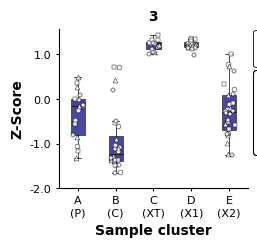

CesA7_IRX3_Potri.006G181900.v4.1


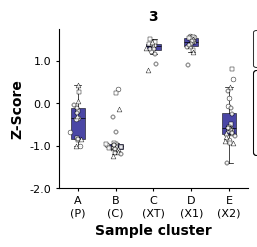

CesA7_IRX3_Potri.018G103900.v4.1


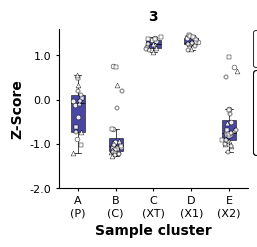

CesA8_IRX1_Potri.004G059600.v4.1


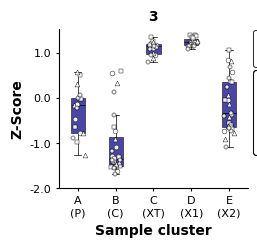

CesA8_IRX1_Potri.011G069600.v4.1


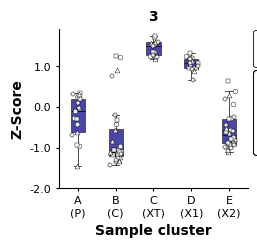

IRX10_Potri.001G068100.v4.1


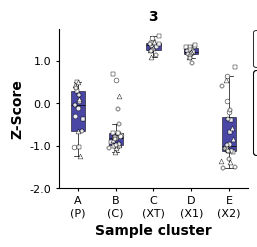

IRX10_Potri.003G162000.v4.1


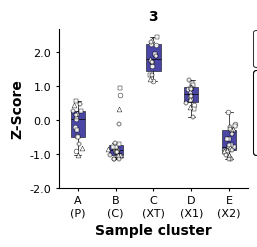

IRX10L_Potri.012G109200.v4.1


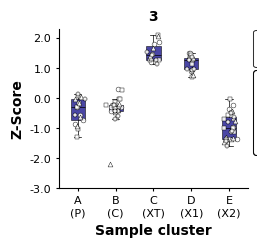

IRX10L_Potri.012G109600.v4.1


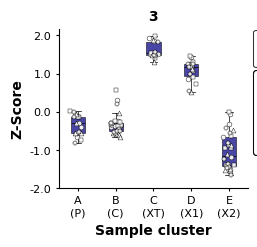

IRX10L_Potri.015G107200.v4.1


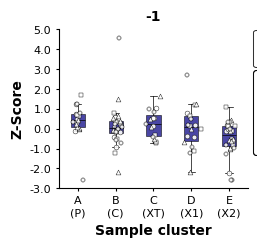

IRX10L_Potri.015G116700.v4.1


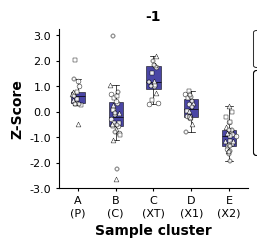

IRX9_Potri.006G131000.v4.1


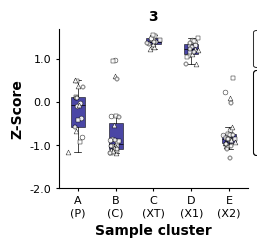

IRX9_Potri.016G086400.v4.1


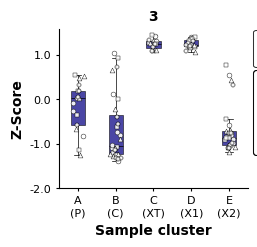

IRX9L_Potri.002G107300.v4.1


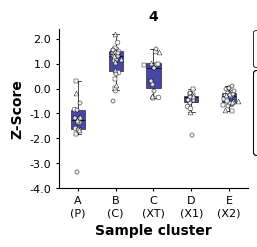

IRX9L_Potri.006G240200.v4.1


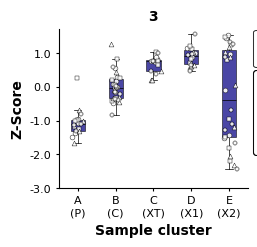

IRX14L_Potri.005G141500.v4.1


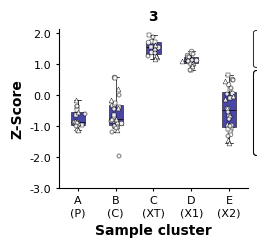

IRX14L_Potri.007G047500.v4.1


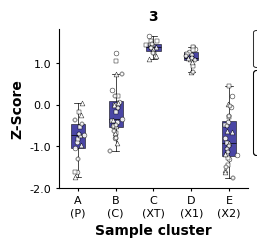

GUX1_Potri.005G061600.v4.1


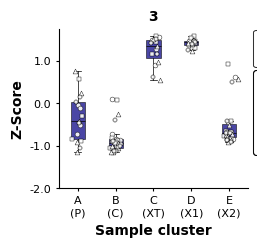

GUX1_Potri.007G107200.v4.1


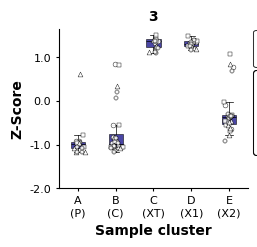

GUX2_Potri.014G029900.v4.1


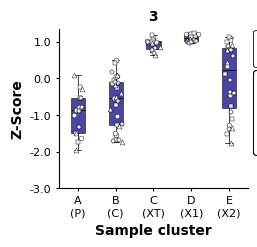

GUX3_Potri.005G187900.v4.1


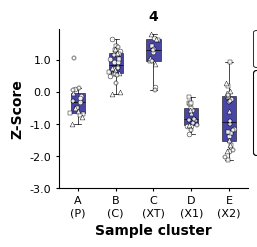

GUX5_Potri.005G033500.v4.1


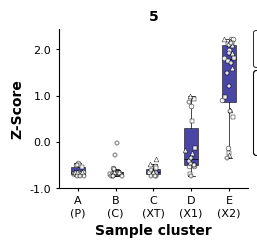

GUX5_Potri.013G022900.v4.1


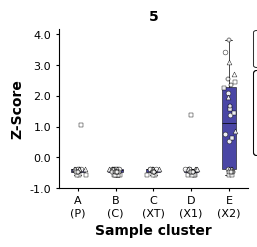

GXM1_Potri.003G003801.v4.1


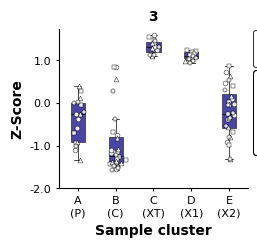

GXM1_Potri.004G226800.v4.1


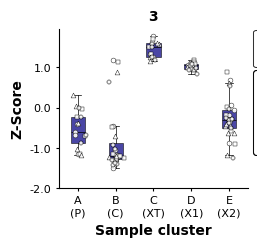

GXM3_Potri.013G102200.v4.1


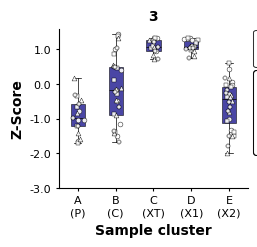

GXM3_Potri.019G076300.v4.1


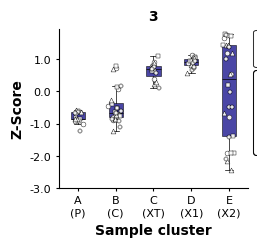

FRA8_Potri.009G006500.v4.1


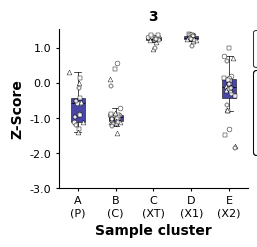

IRX8_Potri.001G416800.v4.1


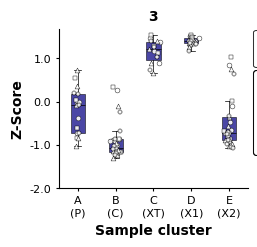

IRX8_Potri.011G132600.v4.1


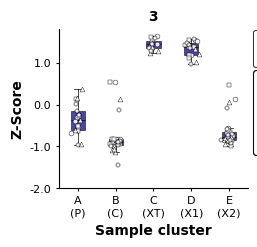

PARVUS_Potri.002G132900.v4.1


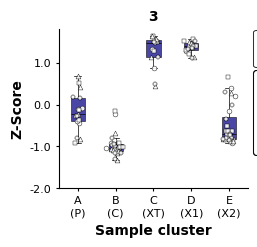

PARVUS_Potri.014G040300.v4.1


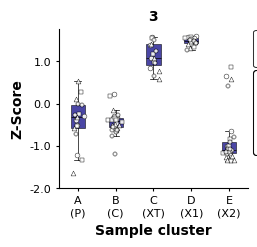

ESK1_Potri.008G069900.v4.1


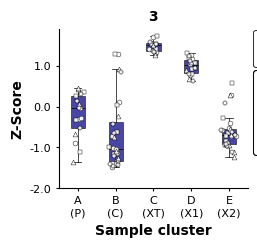

ESK1_Potri.008G069950.v4.1


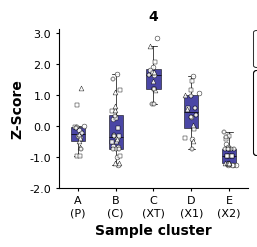

ESK1_Potri.008G070000.v4.1


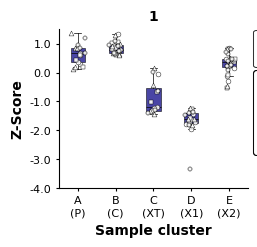

ESK1_Potri.008G070200.v4.1


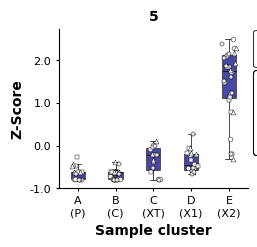

ESK1_Potri.010G187300.v4.1


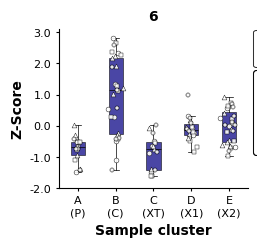

ESK1_Potri.010G187401.v4.1


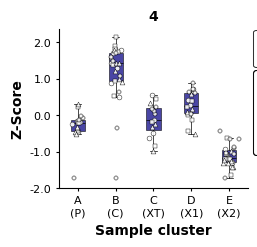

ESK1_Potri.010G187500.v4.1


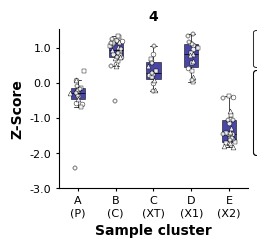

ESK1_Potri.010G187600.v4.1


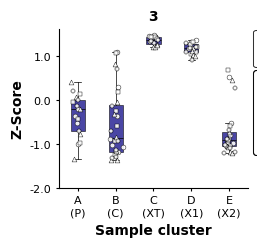

TBL3_Potri.016G119100.v4.1


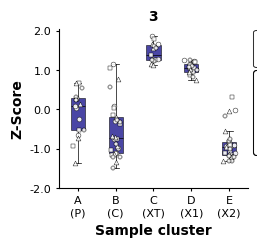

TBL31_Potri.001G376700.v4.1


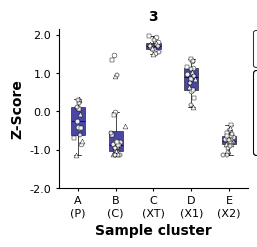

TBL33_Potri.008G073300.v4.1


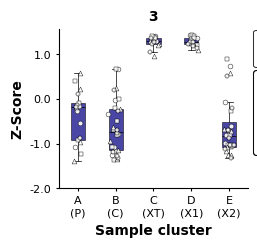

TBL33_Potri.010G184000.v4.1


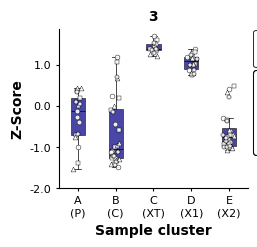

TBL34_Potri.016G125500.v4.1


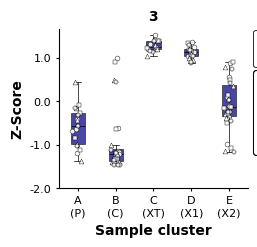

TBL35_Potri.016G125600.v4.1


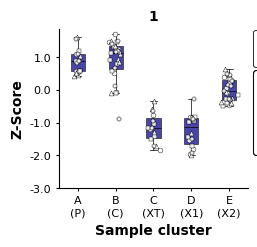

CSLA2_Potri.004G189000.v4.1


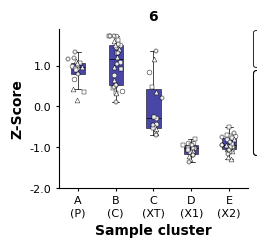

CSLA2_Potri.009G149700.v4.1


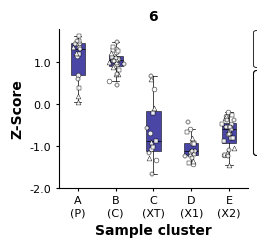

CSLA9_Potri.006G116900.v4.1


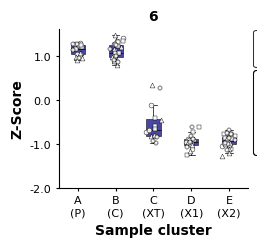

CSLA9_Potri.008G026400.v4.1


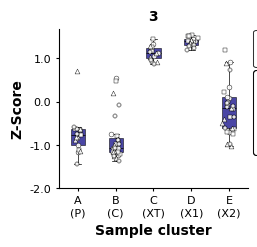

CSLA9_Potri.010G234100.v4.1


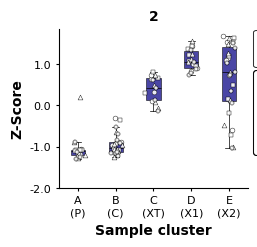

MOAT1_Potri.001G093800.v4.1


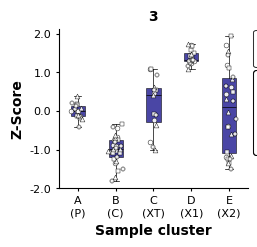

MOAT1_Potri.003G137800.v4.1


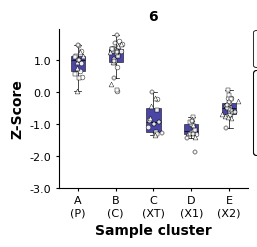

MOAT3_Potri.002G168400.v4.1


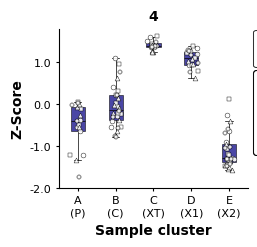

MOAT3_Potri.014G095800.v4.1


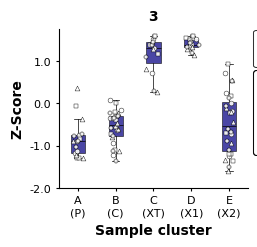

Lignin
PAL1_Potri.006G126800.v4.1


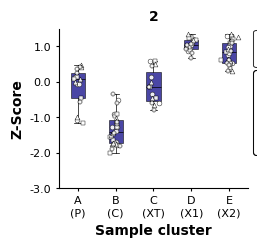

PAL1_Potri.008G038200.v4.1


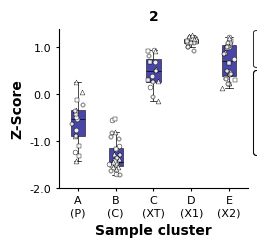

PAL1_Potri.010G224200.v4.1


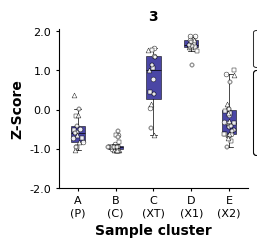

PAL1_Potri.016G091100.v4.1


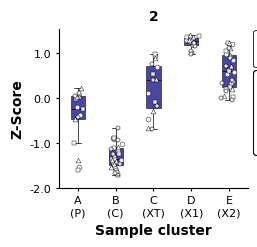

PAL2_Potri.010G224100.v4.1


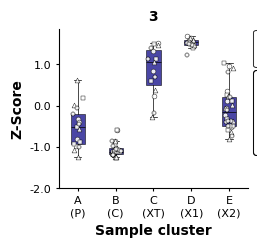

C4H_Potri.006G078101.v4.1


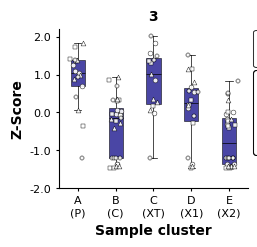

C4H_Potri.013G157900.v4.1


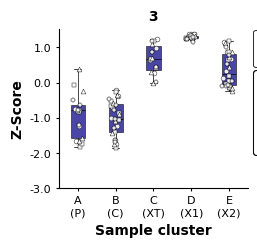

C4H_Potri.018G146100.v4.1


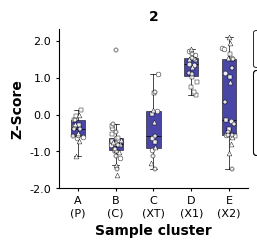

C4H_Potri.019G130700.v4.1


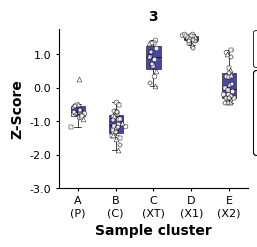

4CL3_Potri.001G036900.v4.1


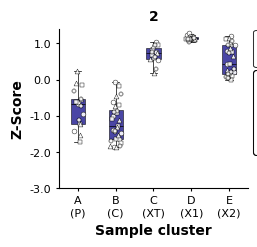

4CL3_Potri.003G188500.v4.1


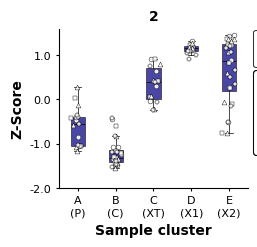

4CL3_Potri.006G169700.v4.1


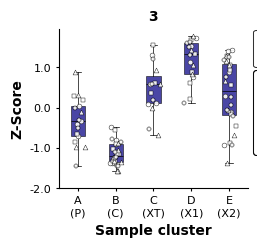

4CL3_Potri.018G094200.v4.1


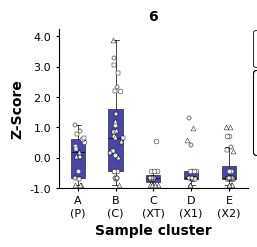

4CL3_Potri.019G049500.v4.1


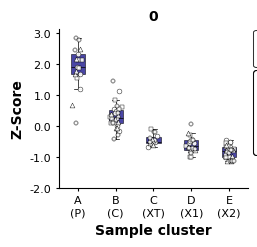

CCR1_IRX4_Potri.001G045000.v4.1


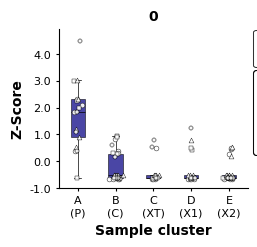

CCR1_IRX4_Potri.001G045100.v4.1


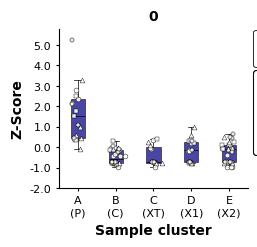

CCR1_IRX4_Potri.001G045500.v4.1


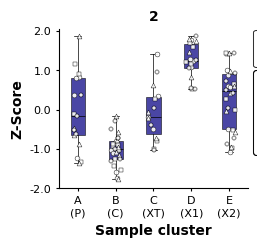

CCR1_IRX4_Potri.001G045600.v4.1


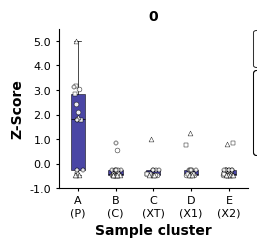

CCR1_IRX4_Potri.001G045800.v4.1


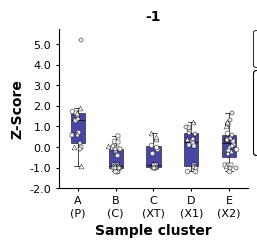

CCR1_IRX4_Potri.001G046100.v4.1


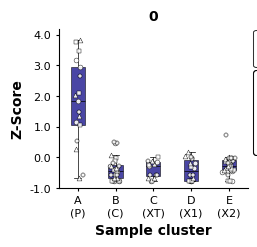

CCR1_IRX4_Potri.001G046400.v4.1


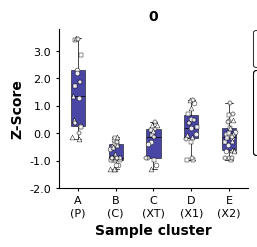

CCR1_IRX4_Potri.003G181400.v4.1


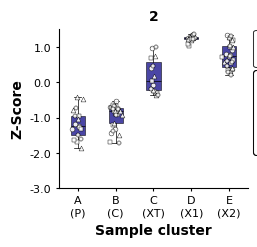

CAD1_Potri.011G148100.v4.1


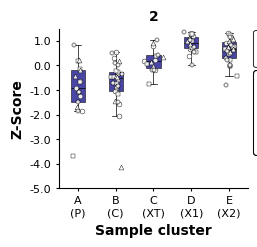

CAD1_Potri.011G148200.v4.1


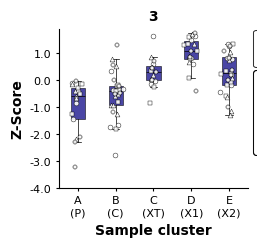

CAD1_Potri.016G023300.v4.1


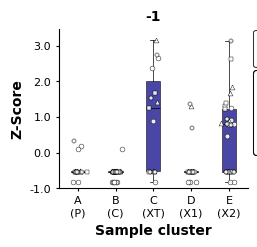

CAD4_Potri.009G095800.v4.1


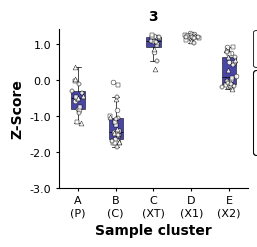

CAD6_Potri.016G078300.v4.1


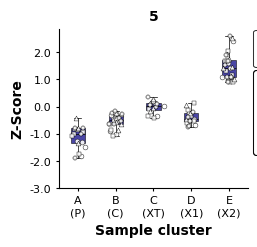

CAD7_Potri.001G268600.v4.1


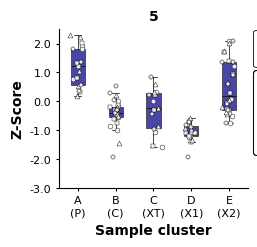

CAD7_Potri.006G199100.v4.1


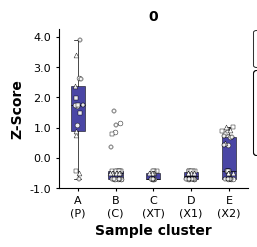

CAD7_Potri.009G063300.v4.1


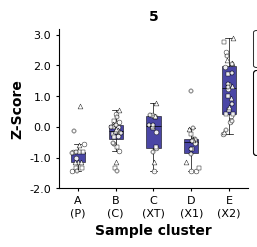

CAD7_Potri.009G063400.v4.1


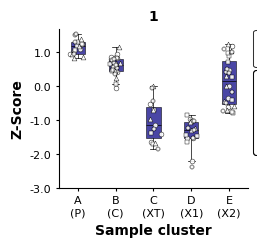

CAD9_Potri.001G307200.v4.1


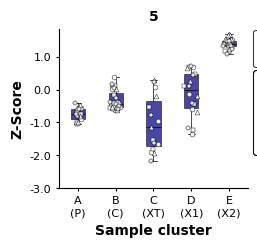

CAD9_Potri.002G018300.v4.1


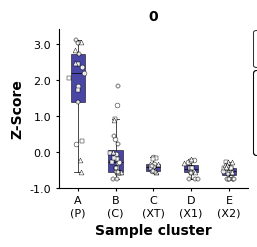

HCT_Potri.001G042900.v4.1


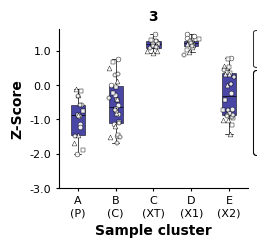

HCT_Potri.003G183900.v4.1


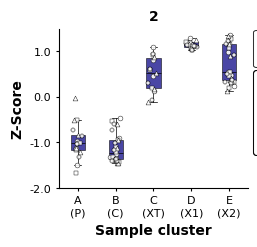

HCT_Potri.018G104700.v4.1


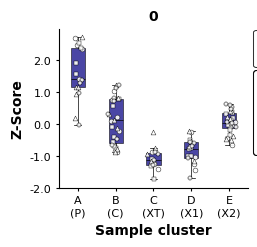

C3H_Potri.006G033300.v4.1


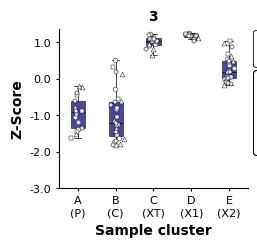

C3H_Potri.016G031100.v4.1


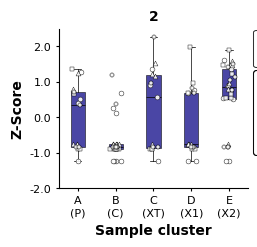

CCoAMT_Potri.008G136600.v4.1


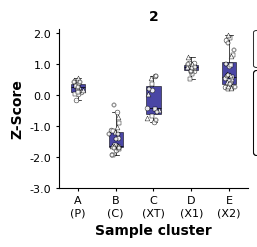

F5H_Potri.005G117500.v4.1


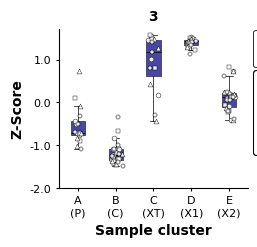

F5H_Potri.007G016400.v4.1


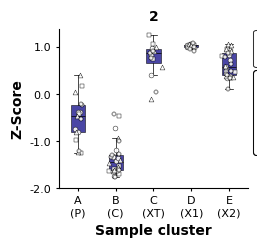

F5H_Potri.007G084400.v4.1


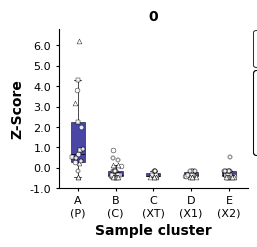

COMT_Potri.001G451100.v4.1


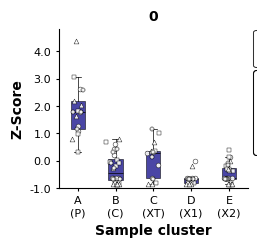

COMT_Potri.002G076766.v4.1


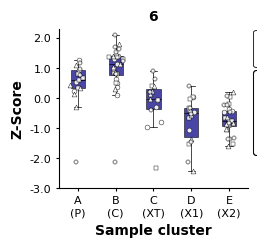

COMT_Potri.011G150500.v4.1


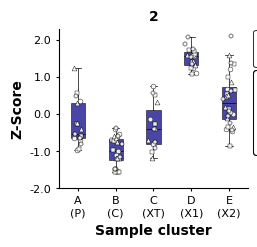

COMT_Potri.012G006400.v4.1


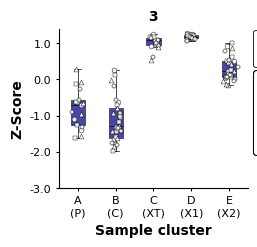

COMT_Potri.013G017210.v4.1


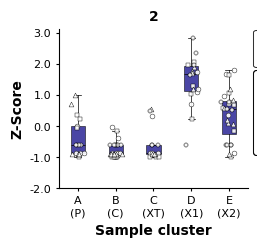

COMT_Potri.014G106500.v4.1


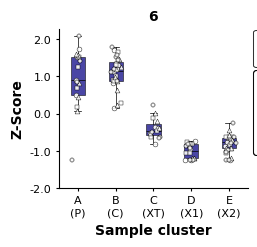

COMT_Potri.014G106600.v4.1


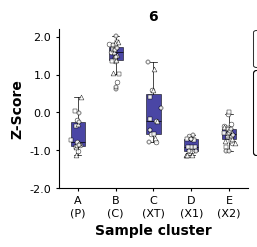

COMT_Potri.015G003100.v4.1


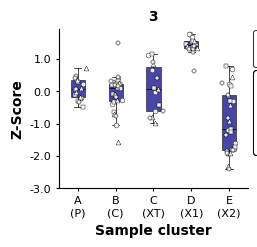

COMT_Potri.016G101600.v4.1


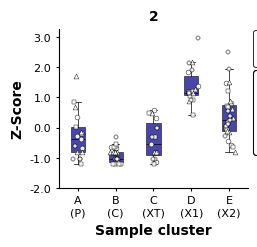

CSE_Potri.001G175000.v4.1


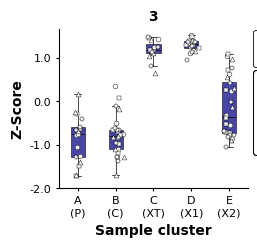

CSE_Potri.003G059200.v4.1


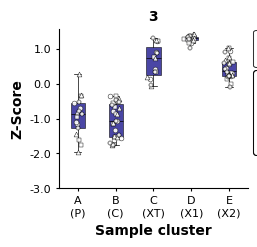

SCW_TF
VND1_Potri.005G116800.v4.1


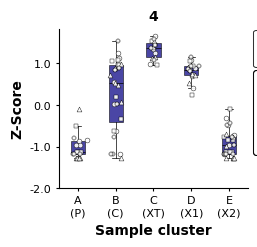

VND1_Potri.007G014400.v4.1


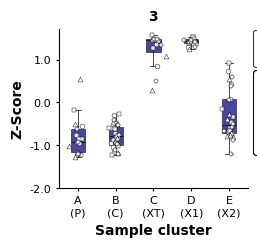

VND4_Potri.001G120000.v4.1


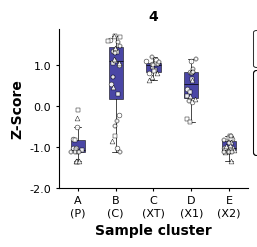

VND4_Potri.003G113000.v4.1


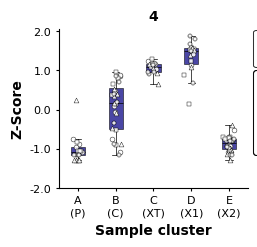

VND4_Potri.012G126500.v4.1


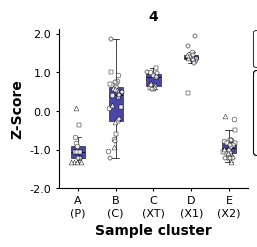

VND4_Potri.015G127400.v4.1


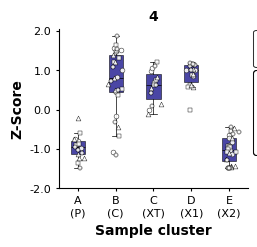

VND7_Potri.013G113100.v4.1


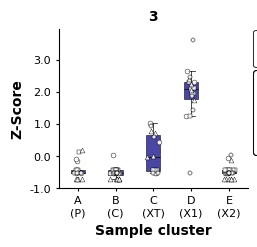

VND7_Potri.015G002900.v4.1


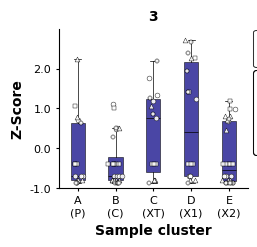

SND1_Potri.011G153300.v4.1


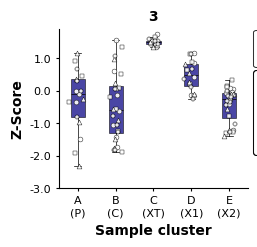

NST1_Potri.001G448400.v4.1


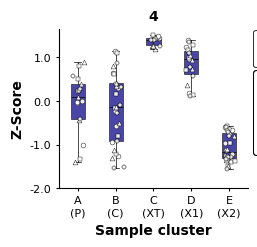

NST1_Potri.002G178700.v4.1


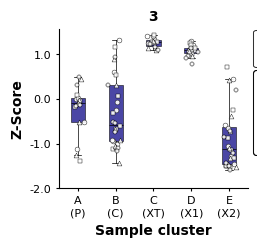

NST1_Potri.014G104800.v4.1


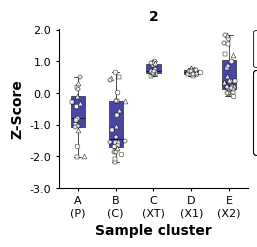

MYB46_Potri.001G258700.v4.1


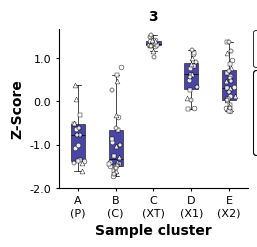

MYB46_Potri.009G053900.v4.1


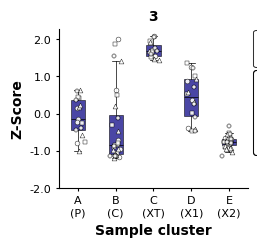

MYB83_Potri.001G267300.v4.1


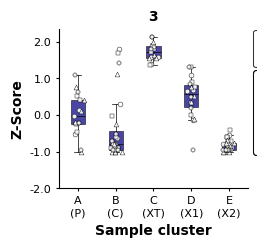

MYB83_Potri.009G061500.v4.1


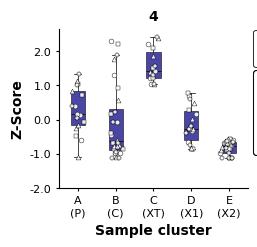

MYB4_Potri.004G138000.v4.1


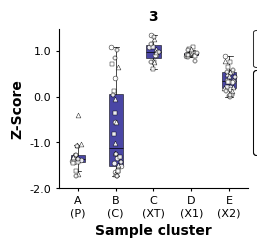

MYB4_Potri.004G174400.v4.1


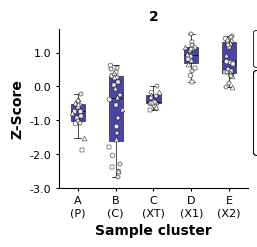

MYB4_Potri.005G112000.v4.1


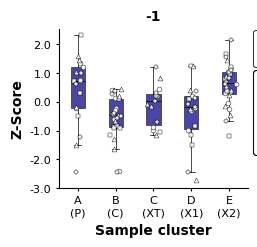

MYB4_Potri.006G221800.v4.1


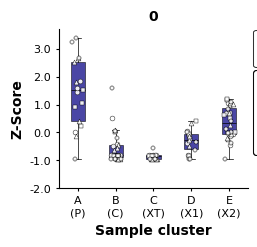

MYB4_Potri.008G128500.v4.1


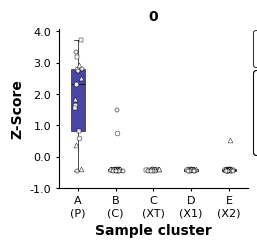

MYB4_Potri.009G134000.v4.1


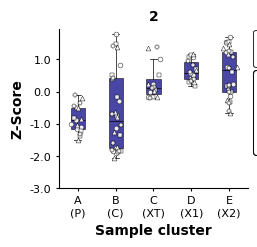

MYB4_Potri.010G114000.v4.1


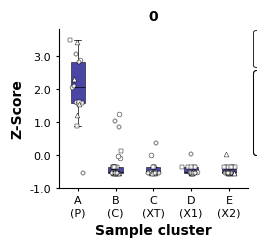

MYB4_Potri.018G049200.v4.1


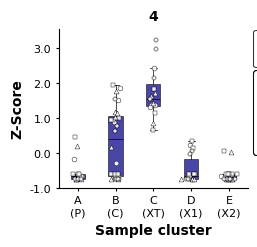

MYB7_Potri.014G100800.v4.1


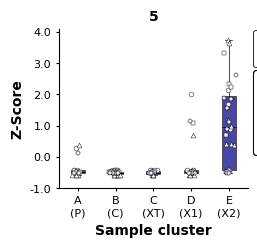

MYB7_Potri.018G049600.v4.1


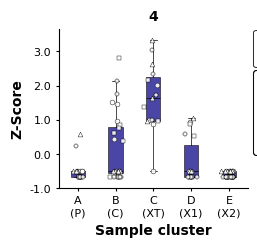

MYB58_Potri.005G096600.v4.1


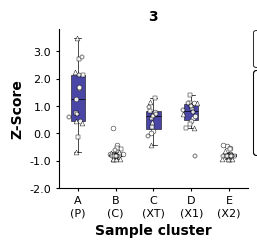

MYB58_Potri.007G067600.v4.1


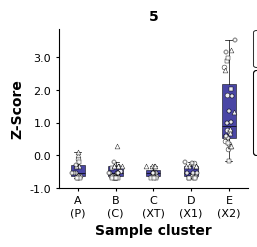

SND2_Potri.004G049300.v4.1


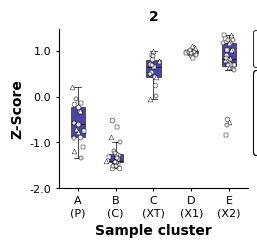

SND2_Potri.007G135300.v4.1


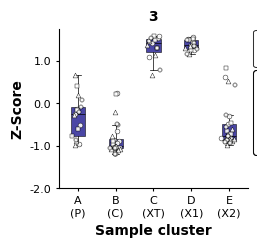

SND2_Potri.011G058400.v4.1


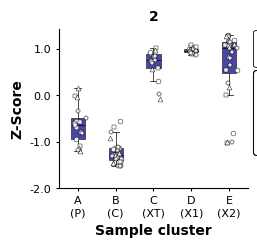

SND2_Potri.017G016700.v4.1


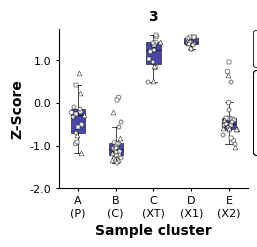

MYB42_Potri.001G118800.v4.1


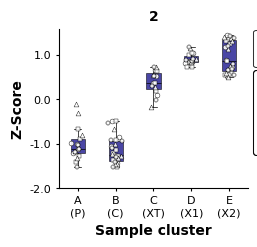

MYB42_Potri.003G114100.v4.1


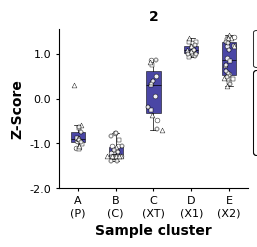

MYB42_Potri.012G127700.v4.1


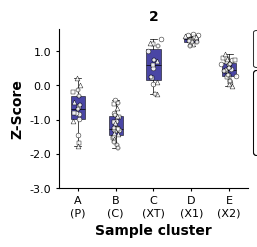

MYB42_Potri.015G129100.v4.1


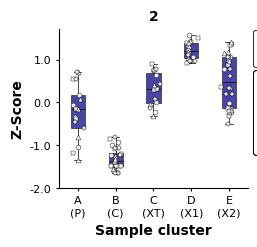

MYB43_Potri.004G086300.v4.1


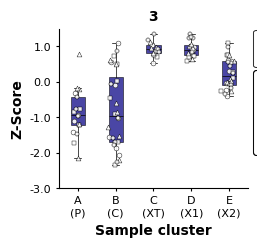

MYB43_Potri.017G130300.v4.1


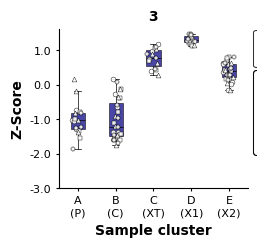

MYB52_Potri.002G073500.v4.1


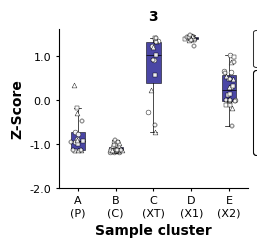

MYB52_Potri.005G186400.v4.1


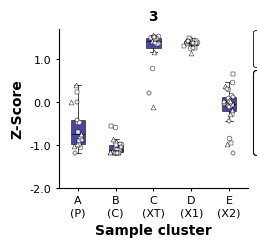

MYB52_Potri.007G134500.v4.1


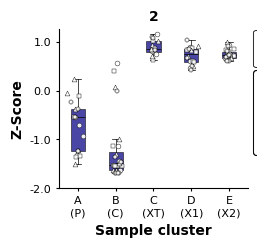

MYB52_Potri.012G039400.v4.1


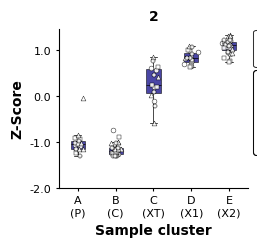

MYB52_Potri.015G033600.v4.1


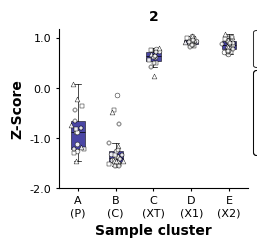

MYB52_Potri.017G017600.v4.1


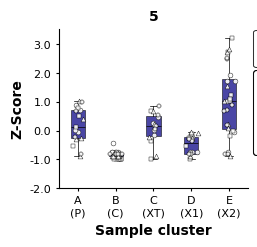

MYB69_Potri.005G063200.v4.1


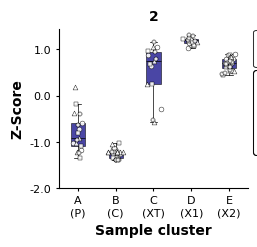

MYB69_Potri.007G106100.v4.1


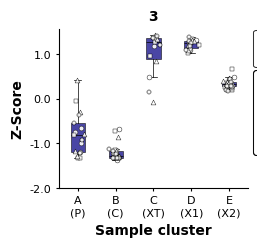

MYB103_Potri.001G099800.v4.1


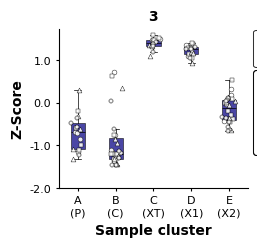

MYB103_Potri.003G132000.v4.1


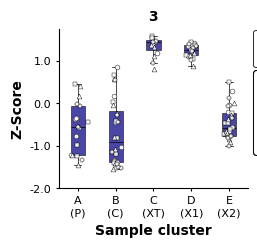

KNAT7_Potri.001G112200.v4.1


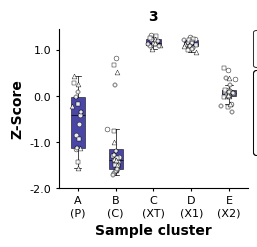

VC
CLE41_Potri.002G241300.v4.1


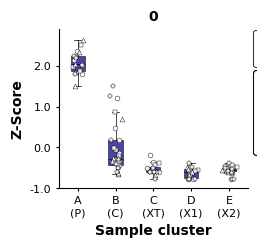

CLE41_Potri.012G019400.v4.1


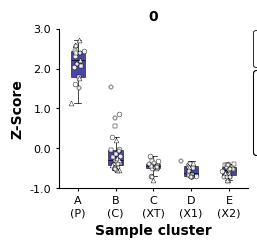

WOX4_Potri.002G124100.v4.1


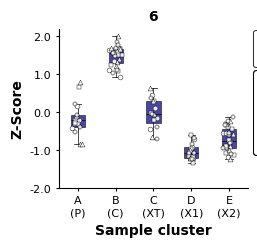

WOX4_Potri.014G025300.v4.1


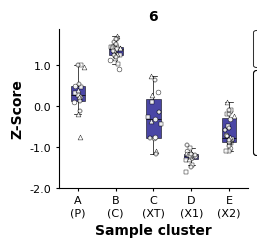

BP_KNAT1_Potri.002G113300.v4.1


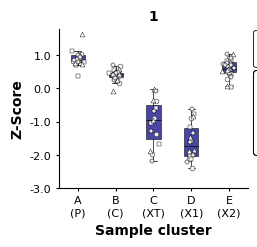

PXY_Potri.001G126100.v4.1


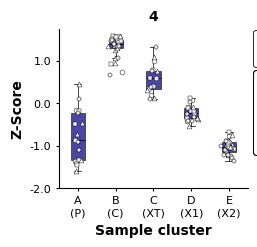

PXY_Potri.003G107600.v4.1


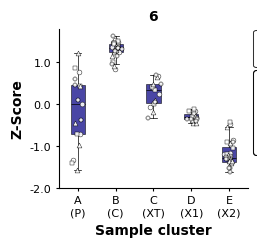

PXL1_Potri.013G048800.v4.1


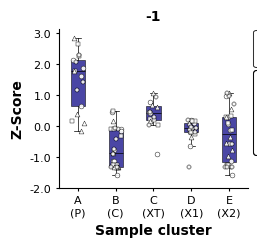

PXL2_Potri.002G256500.v4.1


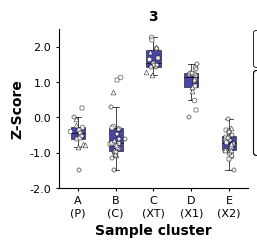

MP_Potri.002G024700.v4.1


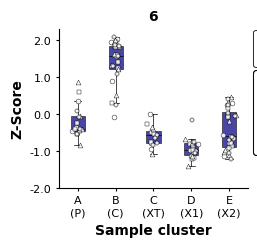

MP_Potri.005G236700.v4.1


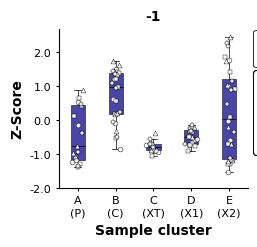

ARF7_Potri.006G077800.v4.1


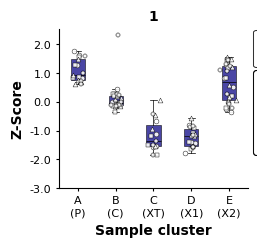

ARF7_Potri.006G138500.v4.1


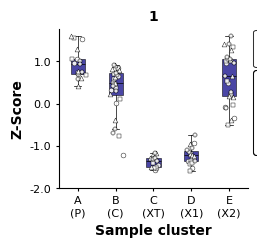

ARF19_Potri.018G063000.v4.1


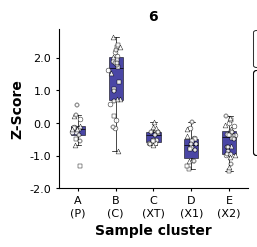

T5L_Potri.008G116000.v4.1


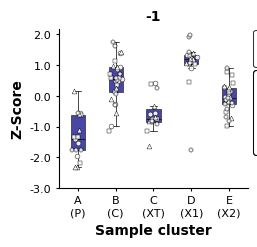

T5L_Potri.010G130000.v4.1


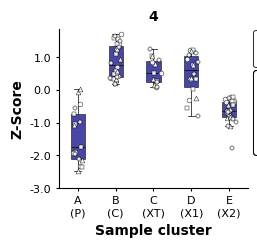

T5L_Potri.019G089000.v4.1


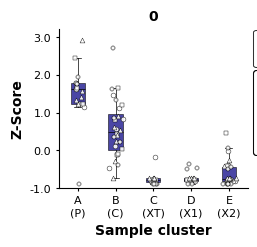

LHW_Potri.001G086000.v4.1


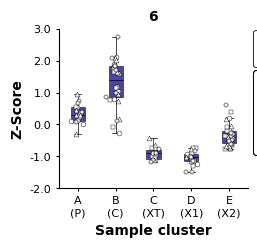

LHW_Potri.001G216900.v4.1


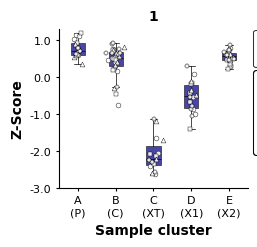

LHW_Potri.003G144900.v4.1


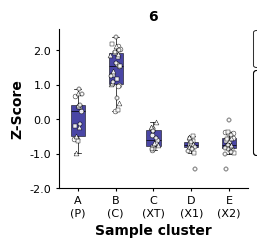

LHW_Potri.006G090000.v4.1


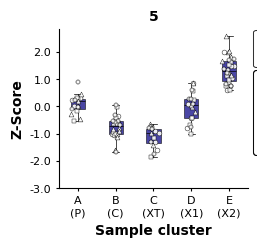

LHW_Potri.009G017700.v4.1


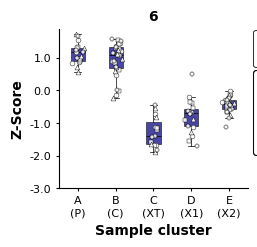

ERECTA_Potri.006G220100.v4.1


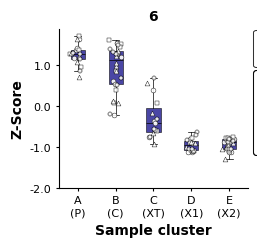

EPFL4_Potri.010G082200.v4.1


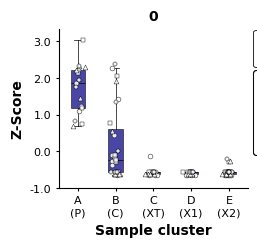

SOBIR1_Potri.012G090500.v4.1


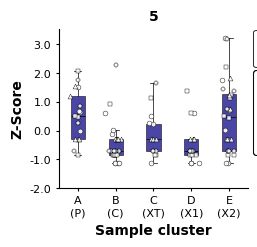

SOBIR1_Potri.015G086800.v4.1


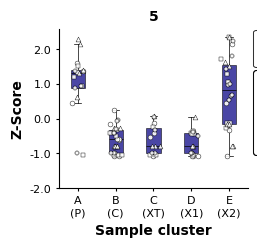

MOL1_Potri.006G189000.v4.1


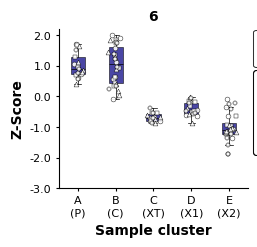

MOL1_Potri.018G113000.v4.1


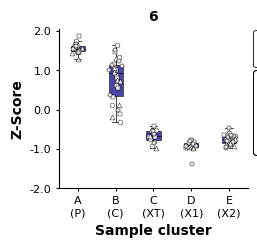

HB8_Potri.006G237500.v4.1


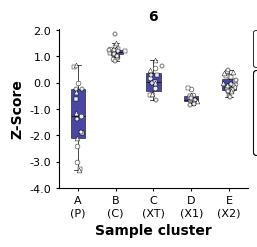

HB8_Potri.018G045100.v4.1


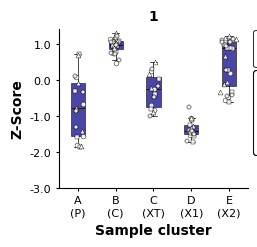

CRN_Potri.001G188800.v4.1


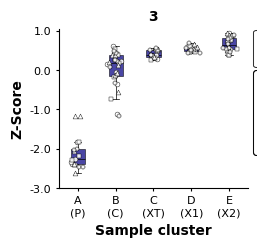

CRN_Potri.003G050100.v4.1


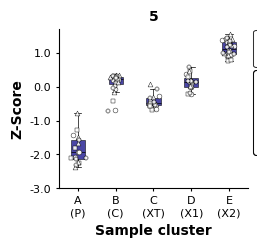

REV_Potri.004G211300.v4.1


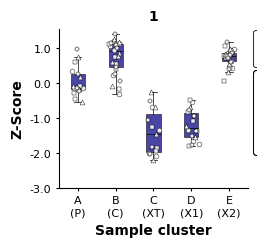

REV_Potri.009G014500.v4.1


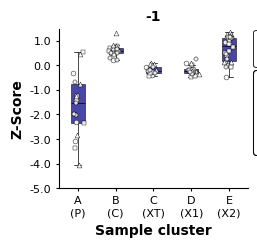

PHB_Potri.001G372300.v4.1


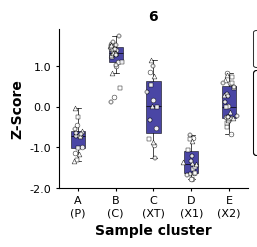

PHB_Potri.011G098300.v4.1


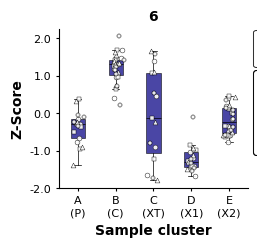

SHR_Potri.007G063300.v4.1


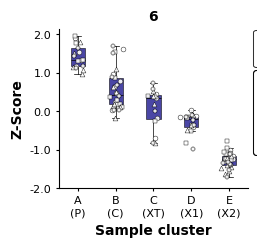

SHR_Potri.007G132000.v4.1


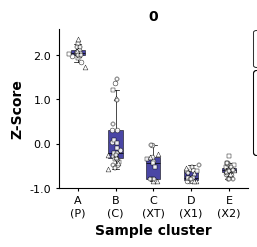

SHR_Potri.017G019900.v4.1


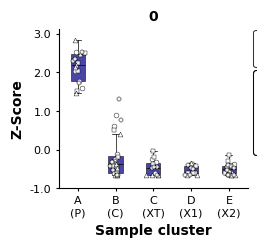

SCR_Potri.016G143833.v4.1


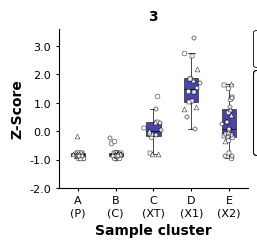

JKD_Potri.006G129300.v4.1


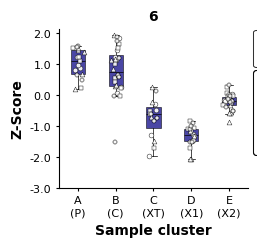

JKD_Potri.016G088500.v4.1


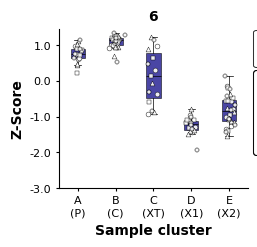

PEAR1_Potri.006G084200.v4.1


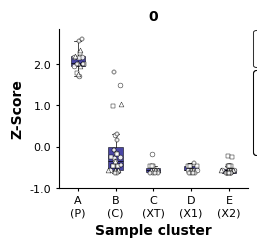

TMO6_Potri.005G134200.v4.1


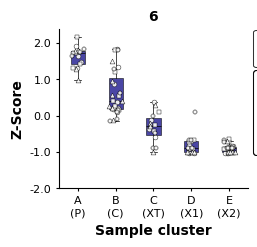

TMO6_Potri.007G038100.v4.1


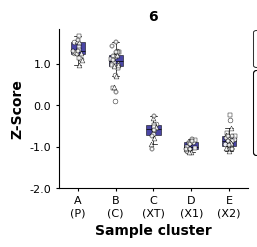

HCA2_Potri.012G081300.v4.1


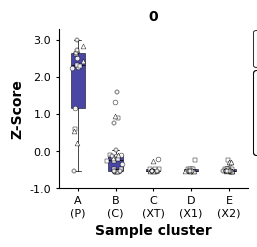

HCA2_Potri.015G077100.v4.1


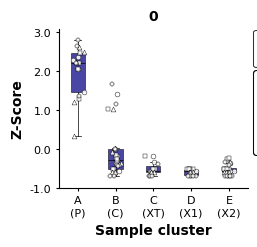

KAN1_Potri.004G082400.v4.1


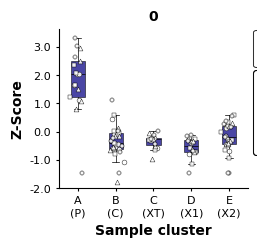

KAN1_Potri.012G042100.v4.1


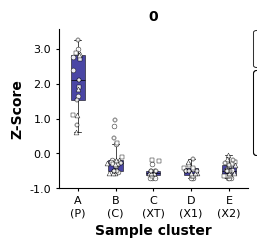

KAN1_Potri.015G031600.v4.1


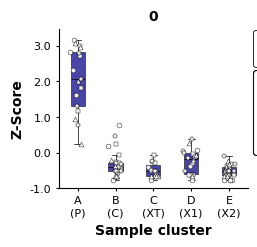

KAN1_Potri.017G137600.v4.1


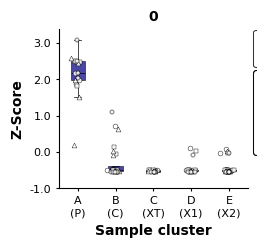

KAN2_Potri.001G137600.v4.1


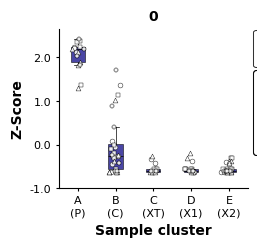

KAN2_Potri.003G096300.v4.1


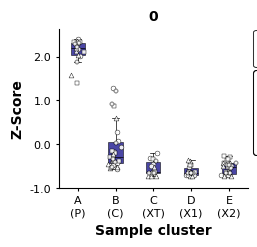

KAN4_Potri.002G130200.v4.1


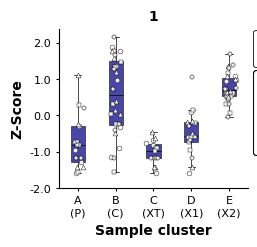

KAN4_Potri.014G037200.v4.1


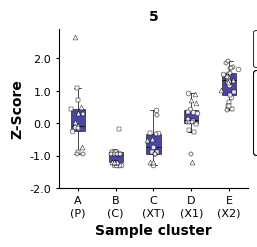

IPT1_Potri.010G123801.v4.1


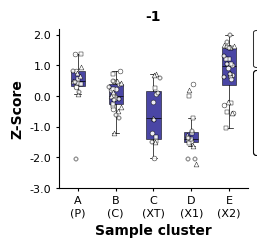

IPT3_Potri.014G139300.v4.1


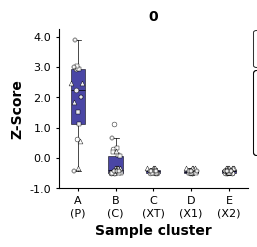

IPT5_Potri.008G202200.v4.1


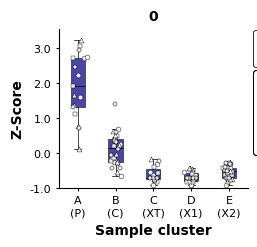

IPT5_Potri.010G030500.v4.1


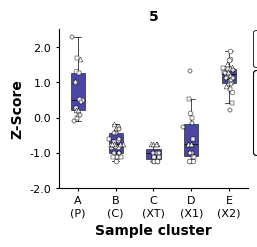

LOG4_Potri.006G127400.v4.1


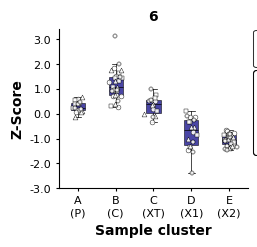

LOG4_Potri.016G090500.v4.1


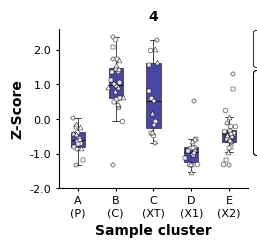

AHP6_Potri.001G191900.v4.1


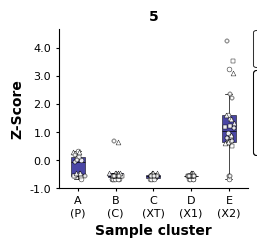

BIN2_Potri.004G059000.v4.1


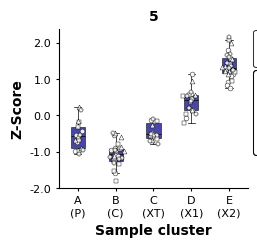

BIN2_Potri.011G068600.v4.1


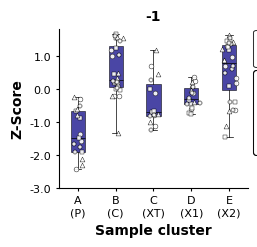

BIL1_Potri.016G045401.v4.1


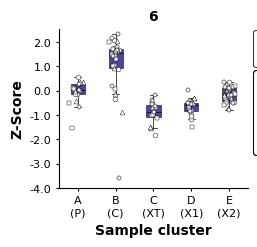

BES1_Potri.016G125700.v4.1


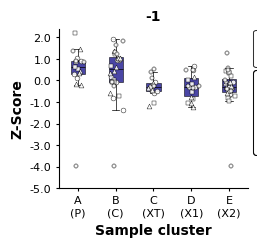

BZR1_Potri.002G133700.v4.1


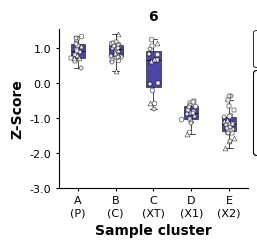

BZR1_Potri.005G126400.v4.1


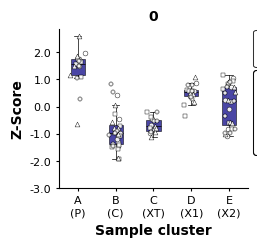

BZR1_Potri.007G030700.v4.1


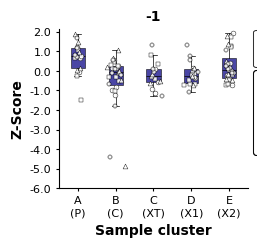

BZR1_Potri.014G041600.v4.1


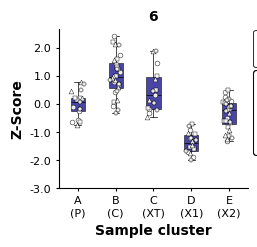

ACL5_Potri.006G222200.v4.1


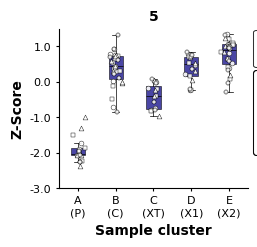

ACL5_Potri.008G151800.v4.1


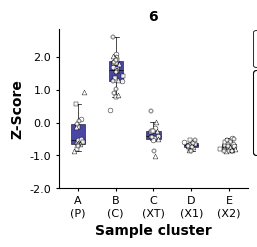

ACL5_Potri.010G089200.v4.1


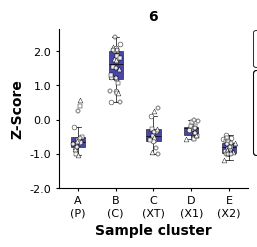

LBD1_Potri.008G043900.v4.1


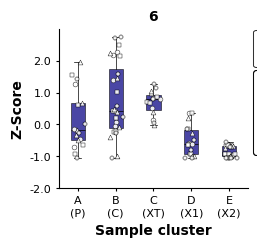

LBD1_Potri.010G217700.v4.1


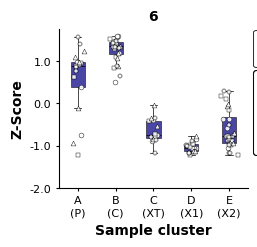

LBD4_Potri.001G081400.v4.1


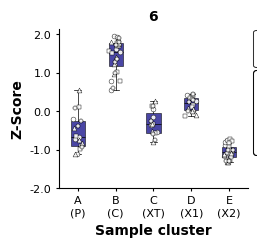

LBD4_Potri.003G149000.v4.1


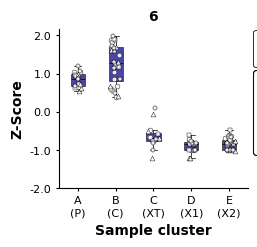

LBD4_Potri.005G097800.v4.1


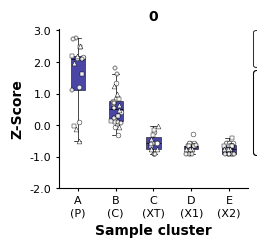

LBD4_Potri.007G066700.v4.1


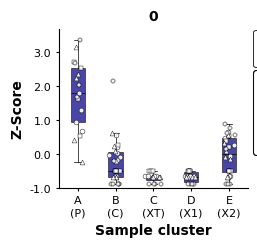

WOX14_Potri.002G008800.v4.1


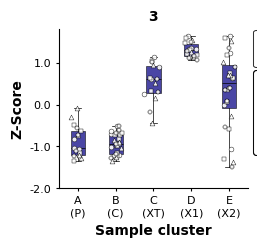

WOX14_Potri.005G252800.v4.1


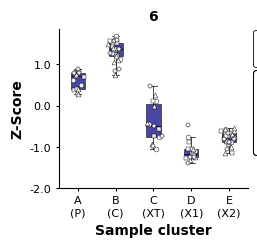

WOX14_Potri.005G101800.v4.1


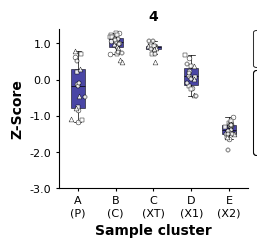

In [29]:
for ivnolvement in goi.Involvement.unique():
    
    print(ivnolvement)
    
    genes = goi.loc[goi.Involvement == ivnolvement,"Geneid"]
    names = goi.loc[goi.Involvement == ivnolvement,"Name"]
    
    for gene, name in zip(genes,names):
        
        print(f"{name}_{gene}")
    
        goiBoxPlot(f"{figurePath}{ivnolvement}", name, gene)